<a href="https://colab.research.google.com/github/Jiyamaria/AI-POWERED-RESUME-SCREENING-USING-NLP-MACHINE-LEARNING/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install required packages
!pip install -q nltk spacy sentence-transformers xgboost imbalanced-learn shap streamlit
!pip install -q --upgrade scikit-learn pandas numpy matplotlib seaborn PyPDF2 pdfminer.six

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 87.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
opencv-python 4.12.0.88 requires 

In [ ]:
#Download NLTK data
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

#Download spaCy model
!python -m spacy download en_core_web_sm -q

#IMPORTS
import numpy as np
import pandas as pd
import re
import os
import json
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from glob import glob

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

#ML imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#NLP imports
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer

#Additional ML
import xgboost as xgb
from imblearn.over_sampling import SMOTE

#Utilities
import joblib
import shap


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import re
import pandas as pd
from pathlib import Path
import PyPDF2
from pdfminer.high_level import extract_text
import shutil

def extract_text_from_pdf(pdf_path):
    """Extract text from PDF with multiple fallbacks"""
    text = ""
    try:
        # Try pdfminer first
        text = extract_text(pdf_path)
        if len(text.strip()) < 100:
            # Fallback to PyPDF2
            with open(pdf_path, 'rb') as f:
                pdf_reader = PyPDF2.PdfReader(f)
                for page in pdf_reader.pages:
                    text += page.extract_text() + "\n"
    except Exception as e:
        print(f"Error extracting {pdf_path}: {str(e)}")
    return text.strip()

def process_resume_dataset(data_root='data/data', output_dir='sorted_data'):
    """
    Process ALL PDFs from category subfolders and organize with new naming

    Folder structure:
    data/data/
    ├── ACCOUNTANT/
    │   ├── 10554236.pdf
    │   └── ...
    ├── ADVOCATE/
    │   ├── ...

    New structure:
    sorted_data/
    ├── ACC_001.txt  # ACCOUNTANT files
    ├── ACC_002.txt
    ├── ADV_001.txt  # ADVOCATE files
    └── ...
    """

    #Create output directory
    os.makedirs(output_dir, exist_ok=True)

    #Category to code mapping (using first 3 letters)
    category_codes = {}
    processed_files = []
    file_counter = {}

    print("Scanning category folders...")

    #Get all category folders
    categories = []
    for item in os.listdir(data_root):
        item_path = os.path.join(data_root, item)
        if os.path.isdir(item_path):
            categories.append(item)

    #Sort categories for consistent ordering
    categories.sort()

    #Assign codes (first 3 uppercase letters)
    for category in categories:
        code = category[:3].upper()
        #Handle duplicates
        if code in category_codes.values():
            code = category[:4].upper() if len(category) >= 4 else code + "2"
        category_codes[category] = code
        file_counter[code] = 1

    print(f"\nFound {len(categories)} categories:")
    for category, code in category_codes.items():
        print(f"  {category:25s} -> {code}")

    print(f"\nProcessing PDFs from {data_root}...")

    total_pdfs = 0
    failed_pdfs = 0

    #Process each category folder
    for category in categories:
        category_path = os.path.join(data_root, category)
        code = category_codes[category]

        #Get all PDFs in this category
        pdf_files = [f for f in os.listdir(category_path)
                    if f.lower().endswith('.pdf')]

        print(f"\nProcessing {category} ({len(pdf_files)} PDFs)")

        #Process each PDF
        for pdf_file in pdf_files:
            pdf_path = os.path.join(category_path, pdf_file)

            #Extract text
            text = extract_text_from_pdf(pdf_path)

            if text and len(text) > 50:  #Valid text
                #Create new filename
                new_filename = f"{code}_{file_counter[code]:03d}.txt"
                new_filepath = os.path.join(output_dir, new_filename)

                #Save extracted text
                with open(new_filepath, 'w', encoding='utf-8') as f:
                    f.write(text)

                #Record metadata
                processed_files.append({
                    'original_file': pdf_file,
                    'new_file': new_filename,
                    'category': category,
                    'category_code': code,
                    'file_number': file_counter[code],
                    'text_length': len(text),
                    'original_path': pdf_path
                })

                file_counter[code] += 1
                total_pdfs += 1
            else:
                failed_pdfs += 1
                print(f"  Failed to extract text from: {pdf_file}")

    print(f"\n Processing complete!")
    print(f"   Total PDFs processed: {total_pdfs}")
    print(f"   Failed extractions: {failed_pdfs}")
    print(f"   Output directory: {output_dir}")

    #Create metadata DataFrame
    metadata_df = pd.DataFrame(processed_files)
    metadata_path = os.path.join(output_dir, 'metadata.csv')
    metadata_df.to_csv(metadata_path, index=False)

    print(f"   Metadata saved to: {metadata_path}")

    return metadata_df

def create_category_mapping(metadata_df, output_file='category_mapping.csv'):
    """Create a mapping file for category codes"""
    mapping = metadata_df[['category', 'category_code']].drop_duplicates()
    mapping = mapping.sort_values('category_code')
    mapping.to_csv(output_file, index=False)
    print(f"Category mapping saved to: {output_file}")
    return mapping

In [ ]:
#Execute the processing
metadata = process_resume_dataset(data_root='/content/drive/Othercomputers/My laptop/Desktop/archive/data/data', output_dir='sorted_data')

#Create category mapping
category_map = create_category_mapping(metadata)

#Display summary
print("\n Dataset Summary:")
print(f"Total categories: {metadata['category'].nunique()}")
print(f"Total files: {len(metadata)}")
print(f"Average text length: {metadata['text_length'].mean():.0f} chars")

#Show sample of processed files
print("\n Sample processed files:")
print(metadata[['category_code', 'new_file', 'text_length']].head(10))

Scanning category folders...

Found 24 categories:
  ACCOUNTANT                -> ACC
  ADVOCATE                  -> ADV
  AGRICULTURE               -> AGR
  APPAREL                   -> APP
  ARTS                      -> ART
  AUTOMOBILE                -> AUT
  AVIATION                  -> AVI
  BANKING                   -> BAN
  BPO                       -> BPO
  BUSINESS-DEVELOPMENT      -> BUS
  CHEF                      -> CHE
  CONSTRUCTION              -> CON
  CONSULTANT                -> CONS
  DESIGNER                  -> DES
  DIGITAL-MEDIA             -> DIG
  ENGINEERING               -> ENG
  FINANCE                   -> FIN
  FITNESS                   -> FIT
  HEALTHCARE                -> HEA
  HR                        -> HR
  INFORMATION-TECHNOLOGY    -> INF
  PUBLIC-RELATIONS          -> PUB
  SALES                     -> SAL
  TEACHER                   -> TEA

Processing PDFs from /content/drive/Othercomputers/My laptop/Desktop/archive/data/data...

Processing ACCOUN

In [ ]:
#CATEGORY MAPPING FROM YOUR DATA

CATEGORY_MAPPING = {
    'ACCOUNTANT': 'ACC',
    'ADVOCATE': 'ADV',
    'AGRICULTURE': 'AGR',
    'APPAREL': 'APP',
    'ARTS': 'ART',
    'AUTOMOBILE': 'AUT',
    'AVIATION': 'AVI',
    'BANKING': 'BAN',
    'BPO': 'BPO',
    'BUSINESS-DEVELOPMENT': 'BUS',
    'CHEF': 'CHE',
    'CONSTRUCTION': 'CON',
    'CONSULTANT': 'CONS',
    'DESIGNER': 'DES',
    'DIGITAL-MEDIA': 'DIG',
    'ENGINEERING': 'ENG',
    'FINANCE': 'FIN',
    'FITNESS': 'FIT',
    'HEALTHCARE': 'HEA',
    'HR': 'HR',
    'INFORMATION-TECHNOLOGY': 'INF',
    'PUBLIC-RELATIONS': 'PUB',
    'SALES': 'SAL',
    'TEACHER': 'TEA'
}

#Reverse mapping for decoding
CODE_TO_CATEGORY = {v: k for k, v in CATEGORY_MAPPING.items()}


In [ ]:
class ResumeDatasetLoader:
    """Loads and processes resume dataset from text files"""

    def __init__(self, data_folder='/content/sorted_data'):
        self.data_folder = data_folder

    def load_from_text_files(self):
        """Load resumes from text files in sorted_data folder"""
        print(f"Loading resumes from {self.data_folder}...")

        all_resumes = []
        all_categories = []

        #Get all text files
        text_files = glob(f"{self.data_folder}/*.txt")
        print(f"Found {len(text_files)} text files")

        for file_path in text_files:
            try:
                #Extract filename
                filename = os.path.basename(file_path)

                #Extract category code from filename
                category_code = filename.split('_')[0]

                #Map code to full category name
                if category_code in CODE_TO_CATEGORY:
                    category = CODE_TO_CATEGORY[category_code]

                    #Read text content
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        text_content = f.read()

                    all_resumes.append(text_content)
                    all_categories.append(category)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

        #Create DataFrame
        data = pd.DataFrame({
            'Category': all_categories,
            'Resume_Text': all_resumes,
            'Category_Code': [CATEGORY_MAPPING[cat] for cat in all_categories]
        })

        print(f"\n Successfully loaded {len(data)} resumes")
        print(f"Categories: {len(data['Category'].unique())}")

        return data

    def load_complete_dataset(self, max_samples_per_category=None):
        """Load complete dataset with optional sampling"""
        data = self.load_from_text_files()

        if max_samples_per_category:
            #Balance dataset by limiting samples per category
            balanced_data = []
            for category in data['Category'].unique():
                category_data = data[data['Category'] == category]
                if len(category_data) > max_samples_per_category:
                    category_data = category_data.sample(max_samples_per_category, random_state=42)
                balanced_data.append(category_data)

            data = pd.concat(balanced_data, ignore_index=True)
            print(f"Balanced dataset to {len(data)} samples ({max_samples_per_category} per category)")

        return data

In [ ]:
loader = ResumeDatasetLoader()
data = loader.load_complete_dataset(max_samples_per_category=None)
data['Resume_Text'][0]

Loading resumes from /content/sorted_data...
Found 2483 text files

✅ Successfully loaded 2483 resumes
Categories: 24


"HR SPECIALIST (INFORMATION SYSTEMS)\nExperience\n02/2013 - 12/2014\nCompany Name ï¼\u200b City , State HR Specialist (Information Systems)\n\nPermanent/FT Supervisor: Iris Murray (910-432-2392)\nServed as Fort Bragg Installation Civilian Personnel Information Systems Manager with full responsibility for establishing and implementing\nautomated personnel policy, providing advisory services, and resolving HR automation user issues. This included system access control, HR\nautomation training administration and instruction, HR automation system software functionality and interface issues, hardware\ntroubleshooting, installation and maintenance, and regulatory and procedural guidance, etc. Systems included: FASCLASS, AutoNoa, USA\nStaffing, Business Objects Applications (SAP Software), CPOL, DCPDS, CSU, eOPF, ASARS, etc.\nDesigned, constructed, tested, deployed, and maintained organizational SharePoint infrastructure. Designed customized web-based\nmanagement tools to improve organization


📊 Final dataset shape: (2483, 3)


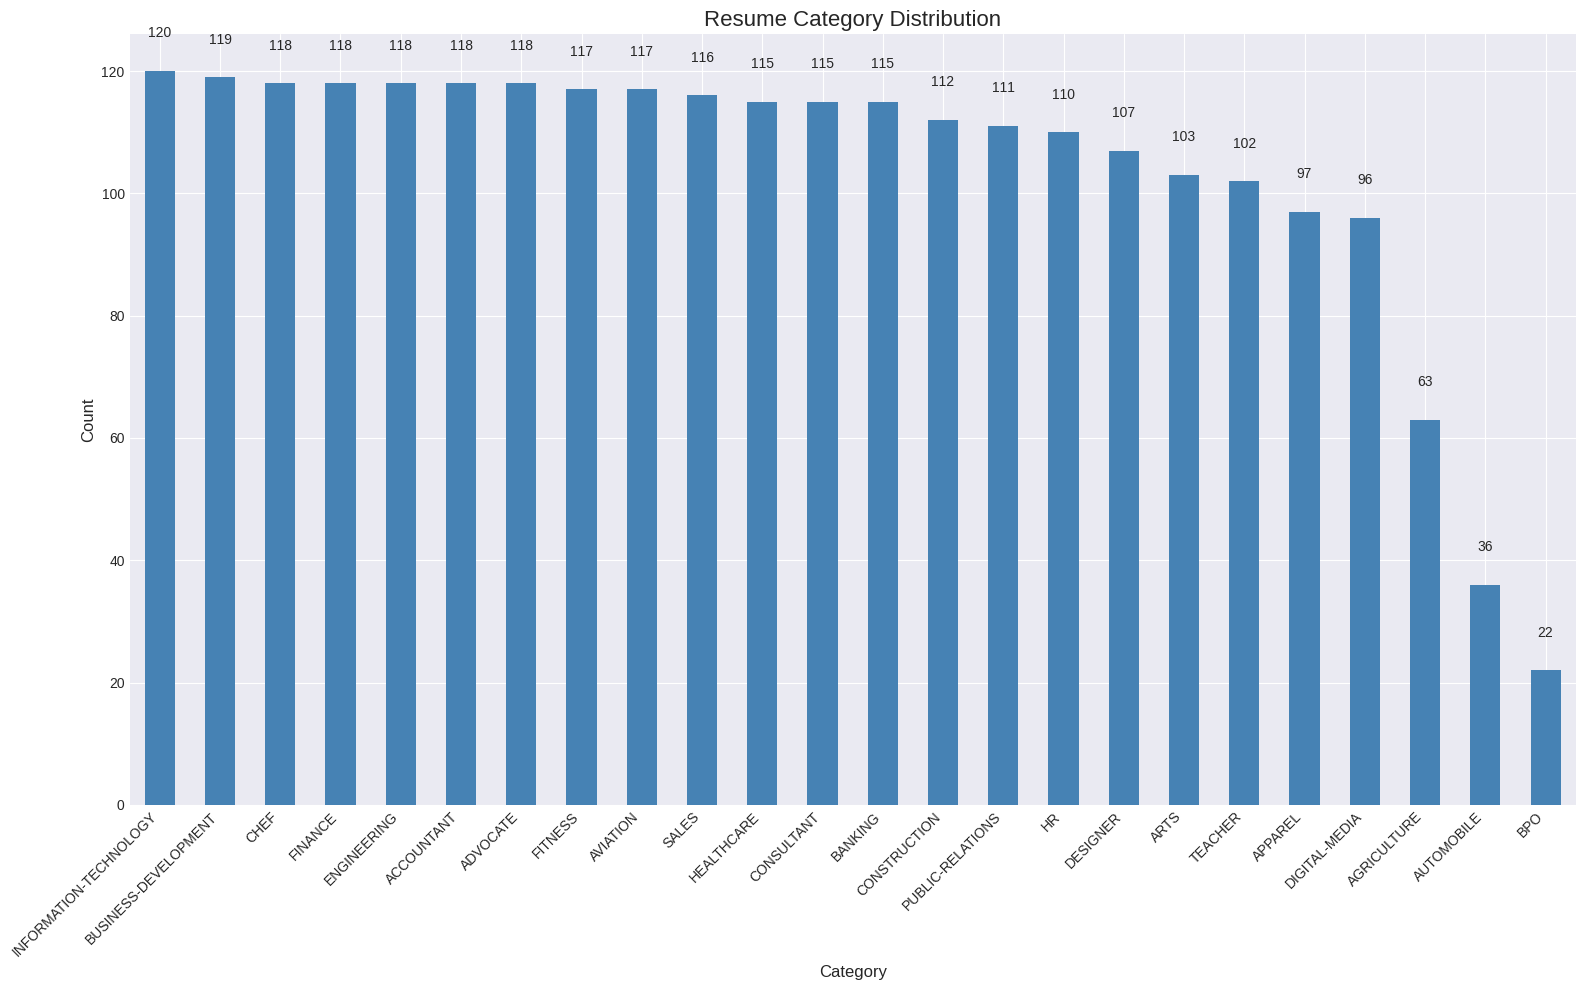


📈 Category statistics:
Total categories: 24
Most common: INFORMATION-TECHNOLOGY (120 resumes)
Least common: BPO (22 resumes)
Imbalance ratio: 5.5x


In [ ]:
#Display data info
print(f"\n Final dataset shape: {data.shape}")

#Visualize category distribution
plt.figure(figsize=(16, 10))
category_counts = data['Category'].value_counts()

ax = category_counts.plot(kind='bar', color='steelblue')
plt.title('Resume Category Distribution', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

#Add count labels on bars
for i, v in enumerate(category_counts):
    ax.text(i, v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n Category statistics:")
print(f"Total categories: {len(category_counts)}")
print(f"Most common: {category_counts.idxmax()} ({category_counts.max()} resumes)")
print(f"Least common: {category_counts.idxmin()} ({category_counts.min()} resumes)")
print(f"Imbalance ratio: {category_counts.max() / category_counts.min():.1f}x")

In [ ]:
#2.TEXT PREPROCESSING (ENHANCED FOR ALL CATEGORIES)

class TextPreprocessor:
    """Enhanced text preprocessing with more features"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        try:
            self.nlp = spacy.load('en_core_web_sm')
        except:
            import subprocess
            subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
            self.nlp = spacy.load('en_core_web_sm')

        #Enhanced skills keywords database for ALL 24 categories
        self.skills_keywords = {
            #Accounting & Finance
            'accounting': ['accounting', 'audit', 'tax', 'financial reporting', 'gaap', 'ifrs',
                          'bookkeeping', 'budgeting', 'forecasting', 'reconciliation'],
            'legal': ['legal', 'litigation', 'contract', 'compliance', 'regulation', 'court',
                     'advocacy', 'attorney', 'law', 'jurisdiction'],
            'agriculture': ['agriculture', 'farming', 'crops', 'irrigation', 'harvest', 'soil',
                           'livestock', 'organic', 'sustainable', 'agribusiness'],
            'apparel': ['fashion', 'apparel', 'garment', 'textile', 'design', 'merchandising',
                       'retail', 'manufacturing', 'quality control', 'production'],
            'arts': ['art', 'creative', 'design', 'visual', 'painting', 'sculpture', 'exhibition',
                    'gallery', 'curation', 'artistic'],
            'automotive': ['automotive', 'vehicle', 'mechanical', 'repair', 'maintenance',
                          'diagnostics', 'engine', 'transmission', 'safety', 'inspection'],
            'aviation': ['aviation', 'aircraft', 'pilot', 'flight', 'airline', 'maintenance',
                        'airport', 'navigation', 'safety', 'faa'],
            'banking': ['banking', 'finance', 'investment', 'loans', 'credit', 'risk',
                       'compliance', 'teller', 'branch', 'financial services'],
            'bpo': ['bpo', 'call center', 'customer service', 'support', 'outsourcing',
                   'voice process', 'non-voice', 'chat', 'email support'],
            'business': ['business development', 'sales', 'marketing', 'strategy', 'growth',
                        'partnership', 'negotiation', 'client acquisition', 'revenue'],
            'culinary': ['culinary', 'cooking', 'chef', 'kitchen', 'food', 'recipe', 'menu',
                        'pastry', 'baking', 'culinary arts'],
            'construction': ['construction', 'building', 'project management', 'site', 'contractor',
                           'architecture', 'civil', 'safety', 'blueprint', 'estimation'],
            'consulting': ['consulting', 'advisory', 'strategy', 'management', 'solution',
                          'client', 'analysis', 'recommendation', 'implementation'],
            'design': ['design', 'graphic', 'ui/ux', 'creative', 'illustration', 'layout',
                      'typography', 'branding', 'visual', 'digital art'],
            'digital_media': ['digital media', 'social media', 'content', 'marketing', 'seo',
                             'analytics', 'campaign', 'engagement', 'viral', 'influencer'],
            'engineering': ['engineering', 'mechanical', 'electrical', 'civil', 'design',
                           'cad', 'project', 'technical', 'analysis', 'simulation'],
            'finance': ['finance', 'financial', 'analysis', 'modeling', 'valuation', 'investment',
                       'portfolio', 'risk management', 'compliance', 'reporting'],
            'fitness': ['fitness', 'training', 'exercise', 'nutrition', 'wellness', 'coaching',
                       'personal training', 'gym', 'health', 'rehabilitation'],
            'healthcare': ['healthcare', 'medical', 'patient', 'hospital', 'nursing', 'clinical',
                          'pharmacy', 'therapy', 'diagnosis', 'treatment'],
            'hr': ['hr', 'human resources', 'recruitment', 'talent', 'compensation', 'benefits',
                  'employee relations', 'training', 'development', 'onboarding'],
            'it': ['programming', 'software', 'development', 'coding', 'database', 'network',
                  'system', 'security', 'cloud', 'devops', 'python', 'java', 'javascript'],
            'pr': ['public relations', 'communications', 'media', 'press', 'brand', 'reputation',
                  'crisis management', 'stakeholder', 'engagement', 'outreach'],
            'sales': ['sales', 'business development', 'account management', 'negotiation',
                     'client acquisition', 'revenue', 'target', 'pipeline', 'closing'],
            'teaching': ['teaching', 'education', 'instruction', 'curriculum', 'lesson planning',
                        'student', 'classroom', 'assessment', 'pedagogy', 'academic']
        }

    def clean_text(self, text):
        """Comprehensive text cleaning"""
        if not isinstance(text, str):
            return ""

        #Convert to lowercase
        text = text.lower()

        #Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)

        #Remove emails
        text = re.sub(r'\S+@\S+', '[EMAIL]', text)

        #Remove phone numbers
        text = re.sub(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]', '[PHONE]', text)

        #Remove special characters but keep some punctuation
        text = re.sub(r'[^\w\s.,!?@\-\']', ' ', text)

        #Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def extract_features(self, text):
        """Extract comprehensive structured features from resume text"""
        features = {}

        #Basic text features
        features['word_count'] = len(text.split())
        features['char_count'] = len(text)
        features['avg_word_length'] = features['char_count'] / max(features['word_count'], 1)

        #Sentence count (approximate)
        sentences = re.split(r'[.!?]+', text)
        features['sentence_count'] = len([s for s in sentences if len(s.strip()) > 0])

        #Extract skills mentions for all categories
        skills_found = {}
        for category, keywords in self.skills_keywords.items():
            category_count = 0
            matched_keywords = []
            for keyword in keywords:
                #Use word boundaries for exact matching
                pattern = r'\b' + re.escape(keyword) + r'\b'
                if re.search(pattern, text):
                    category_count += 1
                    matched_keywords.append(keyword)
            skills_found[category] = {
                'count': category_count,
                'keywords': matched_keywords[:5]  #Store top 5 keywords
            }

        #Add to features
        for category, data in skills_found.items():
            features[f'skills_{category}'] = data['count']

        features['total_skills'] = sum(data['count'] for data in skills_found.values())
        features['unique_skill_categories'] = sum(1 for data in skills_found.values() if data['count'] > 0)

        #Extract experience pattern (years)
        experience_patterns = [
            r'(\d+)\+?\s*(?:years?|yrs?)(?:\s*\+?\s*\d+\s*months?)?\s*(?:of\s*)?experience',
            r'experience\s*(?:of\s*)?(\d+[\+\-\–]?\d*)\s*(?:years?|yrs?)',
            r'(\d+)\s*-\s*(\d+)\s*years?\s*experience',
            r'(\d+)\s*years?\s*experience'
        ]

        experience_years = 0
        experience_mentions = []
        for pattern in experience_patterns:
            matches = re.findall(pattern, text)
            for match in matches:
                if isinstance(match, tuple):
                    for m in match:
                        if m and m.isdigit():
                            years = int(m)
                            experience_years = max(experience_years, years)
                            experience_mentions.append(years)
                elif match and match.isdigit():
                    years = int(match)
                    experience_years = max(experience_years, years)
                    experience_mentions.append(years)

        features['experience_years'] = experience_years
        features['experience_mentions'] = len(experience_mentions)

        #Education level detection
        education_keywords = {
            'phd': ['phd', 'ph.d', 'doctorate', 'doctoral'],
            'masters': ['master', 'm.s', 'm.sc', 'm.tech', 'mba', 'msc'],
            'bachelors': ['bachelor', 'b.s', 'b.sc', 'b.tech', 'b.a', 'b.e', 'bachelors'],
            'associate': ['associate', 'a.s', 'a.a', 'diploma']
        }

        education_level = 0  #0: none, 1: associate/diploma, 2: bachelor, 3: master, 4: phd
        education_keywords_found = []

        for level, keywords in education_keywords.items():
            for keyword in keywords:
                pattern = r'\b' + re.escape(keyword) + r'\b'
                if re.search(pattern, text):
                    education_keywords_found.append(keyword)
                    if level == 'phd':
                        education_level = max(education_level, 4)
                    elif level == 'masters':
                        education_level = max(education_level, 3)
                    elif level == 'bachelors':
                        education_level = max(education_level, 2)
                    elif level == 'associate':
                        education_level = max(education_level, 1)

        features['education_level'] = education_level
        features['education_keywords_count'] = len(education_keywords_found)

        #Project mentions
        project_keywords = ['project', 'developed', 'implemented', 'built', 'created',
                           'designed', 'led', 'managed', 'engineered']
        project_count = sum(1 for keyword in project_keywords if re.search(r'\b' + re.escape(keyword) + r'\b', text))
        features['project_mentions'] = project_count

        #Certification mentions
        certification_keywords = ['certified', 'certification', 'certificate', 'license', 'licensed']
        certification_count = sum(1 for keyword in certification_keywords
                                 if re.search(r'\b' + re.escape(keyword) + r'\b', text))
        features['certification_mentions'] = certification_count

        #Contact info presence
        contact_patterns = ['[EMAIL]', '[PHONE]', 'linkedin', 'github']
        contact_count = sum(1 for pattern in contact_patterns if pattern in text)
        features['contact_info_score'] = contact_count

        #Industry-specific features
        features['has_degree'] = 1 if education_level >= 2 else 0
        features['has_experience'] = 1 if experience_years > 0 else 0
        features['has_certifications'] = 1 if certification_count > 0 else 0

        return features

    def preprocess_pipeline(self, texts, extract_features=False, progress_update=True):
        """Complete preprocessing pipeline"""
        print("Starting text preprocessing pipeline...")

        cleaned_texts = []
        all_features = []

        total_texts = len(texts)
        for i, text in enumerate(texts):
            #Clean text
            cleaned = self.clean_text(text)
            cleaned_texts.append(cleaned)

            #Extract features if requested
            if extract_features:
                features = self.extract_features(cleaned)
                all_features.append(features)

            if progress_update and i % 100 == 0 and i > 0:
                print(f"  Processed {i}/{total_texts} texts...")

        print(f" Preprocessing completed! Processed {total_texts} texts.")

        if extract_features:
            features_df = pd.DataFrame(all_features)
            return cleaned_texts, features_df

        return cleaned_texts

In [ ]:
#STEP 2: PREPROCESSING

print("\n\n2. TEXT PREPROCESSING")
print("-"*40)

preprocessor = TextPreprocessor()

#Clean texts and extract features
print("Processing texts...")
cleaned_texts, structured_features = preprocessor.preprocess_pipeline(
    data['Resume_Text'].tolist(),
    extract_features=True,
    progress_update=True
)

#Display feature statistics
print(f"\n Extracted {structured_features.shape[1]} structured features")
print("\nTop 5 features by mean value:")
top_features = structured_features.mean().sort_values(ascending=False).head(5)
for feat, val in top_features.items():
    print(f"  {feat}: {val:.2f}")



2. 🧹 TEXT PREPROCESSING
----------------------------------------
Processing texts...
Starting text preprocessing pipeline...
  Processed 100/2483 texts...
  Processed 200/2483 texts...
  Processed 300/2483 texts...
  Processed 400/2483 texts...
  Processed 500/2483 texts...
  Processed 600/2483 texts...
  Processed 700/2483 texts...
  Processed 800/2483 texts...
  Processed 900/2483 texts...
  Processed 1000/2483 texts...
  Processed 1100/2483 texts...
  Processed 1200/2483 texts...
  Processed 1300/2483 texts...
  Processed 1400/2483 texts...
  Processed 1500/2483 texts...
  Processed 1600/2483 texts...
  Processed 1700/2483 texts...
  Processed 1800/2483 texts...
  Processed 1900/2483 texts...
  Processed 2000/2483 texts...
  Processed 2100/2483 texts...
  Processed 2200/2483 texts...
  Processed 2300/2483 texts...
  Processed 2400/2483 texts...
✅ Preprocessing completed! Processed 2483 texts.

📊 Extracted 40 structured features

Top 5 features by mean value:
  char_count: 5901.36


In [ ]:
 structured_features

,word_count,char_count,avg_word_length,sentence_count,skills_accounting,skills_legal,skills_agriculture,skills_apparel,skills_arts,skills_automotive,...,experience_years,experience_mentions,education_level,education_keywords_count,project_mentions,certification_mentions,contact_info_score,has_degree,has_experience,has_certifications
0,3145,24442,7.771701,175,0,1,0,2,0,1,...,0,0,3,2,6,0,0,1,0,0
1,2003,14165,7.071892,123,1,0,0,1,1,2,...,0,0,2,1,4,0,0,1,0,0
2,2596,17232,6.637904,181,0,4,0,0,0,1,...,0,0,1,1,4,3,0,0,0,1
3,955,6550,6.858639,30,1,0,2,3,1,1,...,0,0,1,1,0,0,0,0,0,0
4,654,4864,7.437309,37,3,0,0,1,1,1,...,0,0,2,1,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478,845,6360,7.526627,43,1,1,0,0,0,3,...,0,0,3,3,4,1,0,1,0,1
2479,712,5168,7.258427,33,2,3,0,1,0,2,...,10,1,1,1,5,1,0,0,1,1
2480,1707,13191,7.727592,85,1,0,0,1,2,2,...,0,0,2,1,6,2,0,1,0,1
2481,709,5133,7.239774,39,0,0,0,1,2,0,...,0,0,2,1,3,1,0,1,0,1


In [ ]:
#3. FEATURE ENGINEERING (ENHANCED)

class FeatureEngineer:
    """Creates multiple feature representations with batch processing"""

    def __init__(self):
        self.tfidf_vectorizer = None
        self.sbert_model = None
        self.scaler = StandardScaler()

    def create_tfidf_features(self, texts, max_features=2000, min_df=2, max_df=0.8):
        """Create enhanced TF-IDF features"""
        print("Creating TF-IDF features...")

        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 3),  #Include trigrams
            min_df=min_df,        #Remove very rare terms
            max_df=max_df,        #Remove very common terms
            sublinear_tf=True,    #Apply sublinear scaling
            analyzer='word'
        )

        tfidf_features = self.tfidf_vectorizer.fit_transform(texts)
        print(f"TF-IDF shape: {tfidf_features.shape}")
        print(f"Vocabulary size: {len(self.tfidf_vectorizer.vocabulary_)}")

        return tfidf_features

    def create_sbert_embeddings(self, texts, model_name='all-MiniLM-L6-v2', batch_size=32):
        """Create Sentence-BERT embeddings with batch processing"""
        print(f"Creating Sentence-BERT embeddings using {model_name}...")

        if self.sbert_model is None:
            try:
                self.sbert_model = SentenceTransformer(model_name)
            except Exception as e:
                print(f"Error loading SBERT model: {str(e)}")
                print("Falling back to paraphrase-MiniLM-L6-v2")
                self.sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

        #Process in batches to avoid memory issues
        embeddings_list = []
        total_batches = (len(texts) + batch_size - 1) // batch_size

        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            batch_embeddings = self.sbert_model.encode(
                batch_texts,
                show_progress_bar=False,
                convert_to_numpy=True,
                normalize_embeddings=True
            )
            embeddings_list.append(batch_embeddings)

            if (i // batch_size) % 10 == 0:
                print(f"  Processed batch {i//batch_size + 1}/{total_batches}...")

        #Concatenate all batches
        sbert_features = np.vstack(embeddings_list)

        print(f" SBERT embeddings shape: {sbert_features.shape}")
        return sbert_features

    def create_combined_features(self, tfidf_features, sbert_features, structured_features=None):
        """Combine all feature types"""
        print("Combining features...")

        #Convert TF-IDF to dense if needed
        if hasattr(tfidf_features, 'toarray'):
            tfidf_dense = tfidf_features.toarray()
        else:
            tfidf_dense = tfidf_features

        #Combine TF-IDF and SBERT
        combined = np.hstack([tfidf_dense, sbert_features])
        print(f"TF-IDF + SBERT shape: {combined.shape}")

        #Add structured features if available
        if structured_features is not None and len(structured_features) > 0:
            # Scale structured features
            structured_scaled = self.scaler.fit_transform(structured_features)
            combined = np.hstack([combined, structured_scaled])
            print(f"+ Structured features: {combined.shape}")

        print(f" Final combined features shape: {combined.shape}")

        return combined

    def save_components(self, path='models/feature_components'):
        """Save feature engineering components"""
        os.makedirs(path, exist_ok=True)

        if self.tfidf_vectorizer:
            joblib.dump(self.tfidf_vectorizer, f'{path}/tfidf_vectorizer.pkl')

        if hasattr(self.scaler, 'mean_'):
            joblib.dump(self.scaler, f'{path}/feature_scaler.pkl')

        print(f" Feature components saved to {path}")

    def load_components(self, path='models/feature_components'):
        """Load feature engineering components"""
        tfidf_path = f'{path}/tfidf_vectorizer.pkl'
        scaler_path = f'{path}/feature_scaler.pkl'

        if os.path.exists(tfidf_path):
            self.tfidf_vectorizer = joblib.load(tfidf_path)
            print(f" Loaded TF-IDF vectorizer from {tfidf_path}")

        if os.path.exists(scaler_path):
            self.scaler = joblib.load(scaler_path)
            print(f" Loaded feature scaler from {scaler_path}")


In [ ]:
#STEP 3: FEATURE ENGINEERING

print("\n\n3.  FEATURE ENGINEERING")
print("-"*40)

feature_engineer = FeatureEngineer()

#Create TF-IDF features
print("Creating TF-IDF features...")
tfidf_features = feature_engineer.create_tfidf_features(
  cleaned_texts,
  max_features=2000,
  min_df=2,
  max_df=0.8
)

#Create SBERT embeddings
print("\nCreating SBERT embeddings...")
sbert_features = feature_engineer.create_sbert_embeddings(
  cleaned_texts,
  model_name='all-MiniLM-L6-v2',
  batch_size=32
)

#Combine features
X_combined = feature_engineer.create_combined_features(
  tfidf_features,
  sbert_features,
  structured_features
)

#Prepare target
y = data['Category'].values



3. 🔧 FEATURE ENGINEERING
----------------------------------------
Creating TF-IDF features...
Creating TF-IDF features...
TF-IDF shape: (2483, 2000)
Vocabulary size: 2000

Creating SBERT embeddings...
Creating Sentence-BERT embeddings using all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  Processed batch 1/78...
  Processed batch 11/78...
  Processed batch 21/78...
  Processed batch 31/78...
  Processed batch 41/78...
  Processed batch 51/78...
  Processed batch 61/78...
  Processed batch 71/78...
✅ SBERT embeddings shape: (2483, 384)
Combining features...
TF-IDF + SBERT shape: (2483, 2384)
+ Structured features: (2483, 2424)
✅ Final combined features shape: (2483, 2424)


In [ ]:
#4. RESUME-JD MATCHING MODULE

class ResumeJDMatcher:
    """Match resumes to job descriptions using semantic similarity"""

    def __init__(self, sbert_model=None):
        if sbert_model is None:
            self.sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
        else:
            self.sbert_model = sbert_model

    def compute_similarity(self, resume_texts, job_description_text):
        """Compute semantic similarity between resumes and job description"""
        print("Computing Resume-JD similarity...")

        #Combine all texts for batch processing
        all_texts = [job_description_text] + resume_texts

        #Get embeddings for all texts
        embeddings = self.sbert_model.encode(
            all_texts,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True
        )

        #JD embedding is the first one
        jd_embedding = embeddings[0]
        resume_embeddings = embeddings[1:]

        # Compute cosine similarity
        similarities = []
        for i, resume_embedding in enumerate(resume_embeddings):
            similarity = np.dot(jd_embedding, resume_embedding) / (
                np.linalg.norm(jd_embedding) * np.linalg.norm(resume_embedding)
            )
            similarities.append(similarity)

        #Convert to numpy array and normalize to 0-1 range
        similarities = np.array(similarities)

        print(f"Similarity statistics:")
        print(f"  Mean: {similarities.mean():.3f}")
        print(f"  Std: {similarities.std():.3f}")
        print(f"  Min: {similarities.min():.3f}")
        print(f"  Max: {similarities.max():.3f}")

        return similarities

    def extract_jd_keywords(self, job_description_text, top_n=20):
        """Extract key requirements from job description"""
        #Simple keyword extraction
        vectorizer = CountVectorizer(
            stop_words='english',
            ngram_range=(1, 2),
            max_features=top_n
        )

        #Fit and transform
        X = vectorizer.fit_transform([job_description_text])
        keywords = vectorizer.get_feature_names_out()

        return keywords

    def create_match_report(self, resume_texts, job_description_text, similarity_scores, top_n=10):
        """Create detailed matching report"""
        #Extract JD keywords
        jd_keywords = self.extract_jd_keywords(job_description_text, top_n=20)

        #Create report for top N matches
        top_indices = np.argsort(similarity_scores)[::-1][:top_n]

        report = {
            'jd_keywords': jd_keywords.tolist(),
            'top_matches': []
        }

        for i, idx in enumerate(top_indices):
            match_info = {
                'rank': i + 1,
                'similarity_score': float(similarity_scores[idx]),
                'resume_preview': resume_texts[idx][:200] + '...' if len(resume_texts[idx]) > 200 else resume_texts[idx]
            }
            report['top_matches'].append(match_info)

        return report


In [ ]:
#STEP 4: TRAIN/TEST SPLIT WITH IMBALANCE HANDLING

print("\n\n4. TRAIN/TEST SPLIT")
print("-"*40)

#Check for class imbalance
category_counts = pd.Series(y).value_counts()
print("\n Class Distribution:")
print(category_counts)

#Calculate imbalance metrics
imbalance_ratio = category_counts.max() / category_counts.min()
print(f"\n Imbalance Statistics:")
print(f"  Imbalance ratio: {imbalance_ratio:.1f}x")
print(f"  Minority classes (<10 samples): {(category_counts < 10).sum()}")

print(X_combined[0:50].shape, y[0:50].shape)
#Split data
X_train, X_test, y_train, y_test = train_test_split(
  X_combined, y,
  test_size=0.2,
  random_state=42,
  stratify=y
)

print(f"\n Dataset Split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Testing set: {X_test.shape[0]} samples")
print(f"  Features per sample: {X_train.shape[1]}")

#Handle class imbalance if severe
if imbalance_ratio > 5.0:
  print(f"\n Severe class imbalance detected ({imbalance_ratio:.1f}x)")
  print("Applying SMOTE for balancing...")

  #Apply SMOTE
  smote = SMOTE(random_state=42, sampling_strategy='auto')
  X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

  print(f"  After SMOTE:")
  print(f"  Training samples: {X_train_balanced.shape[0]} (+{X_train_balanced.shape[0] - X_train.shape[0]})")

  #Use balanced data
  X_train = X_train_balanced
  y_train = y_train_balanced
else:
  print(f"\n Class imbalance is manageable ({imbalance_ratio:.1f}x)")



4. 🎯 TRAIN/TEST SPLIT
----------------------------------------

📈 Class Distribution:
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      119
CHEF                      118
FINANCE                   118
ENGINEERING               118
ACCOUNTANT                118
ADVOCATE                  118
FITNESS                   117
AVIATION                  117
SALES                     116
HEALTHCARE                115
CONSULTANT                115
BANKING                   115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

📊 Imbalance Statistics:
  Imbalance ratio: 5.5x
  Minority classes (<10 samples): 0
(50, 2424) (50,)

📋 Dataset Split:
  Training set: 1986 samples
  Testing set: 49

In [ ]:
X_train.shape


(40, 2424)

In [ ]:
#4. TEXT PREPROCESSING (ENHANCED)

class TextPreprocessor:
    """Enhanced text preprocessing with more features"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        try:
            self.nlp = spacy.load('en_core_web_sm')
        except:
            import subprocess
            subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
            self.nlp = spacy.load('en_core_web_sm')

        #Enhanced skills keywords database
        self.skills_keywords = {
            'programming': ['python', 'java', 'javascript', 'c++', 'sql', 'r', 'matlab', 'scala',
                          'go', 'rust', 'kotlin', 'swift', 'php', 'ruby', 'perl'],
            'ml_ai': ['machine learning', 'deep learning', 'ai', 'artificial intelligence',
                     'neural network', 'tensorflow', 'pytorch', 'keras', 'scikit-learn',
                     'computer vision', 'nlp', 'natural language processing'],
            'web': ['html', 'css', 'react', 'angular', 'vue', 'node.js', 'django', 'flask',
                   'express', 'spring', 'laravel', 'bootstrap', 'jquery'],
            'cloud': ['aws', 'amazon web services', 'azure', 'gcp', 'google cloud',
                     'docker', 'kubernetes', 'terraform', 'ansible', 'jenkins'],
            'databases': ['mysql', 'postgresql', 'mongodb', 'oracle', 'redis', 'cassandra',
                         'sql server', 'dynamodb', 'elasticsearch'],
            'tools': ['git', 'github', 'gitlab', 'jira', 'confluence', 'tableau', 'power bi',
                     'excel', 'linux', 'unix', 'shell', 'bash'],
            'certifications': ['aws certified', 'pmp', 'cissp', 'cfa', 'cisco', 'microsoft certified',
                              'scrum', 'agile', 'six sigma', 'itil'],
            'soft_skills': ['leadership', 'communication', 'teamwork', 'problem solving',
                           'critical thinking', 'creativity', 'adaptability', 'time management',
                           'project management', 'collaboration'],
            'industries': ['healthcare', 'finance', 'banking', 'retail', 'ecommerce', 'tech',
                          'manufacturing', 'education', 'government', 'consulting']
        }

    def clean_text(self, text):
        """Comprehensive text cleaning"""
        if not isinstance(text, str):
            return ""

        #Convert to lowercase
        text = text.lower()

        #Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)

        #Remove emails
        text = re.sub(r'\S+@\S+', '[EMAIL]', text)

        #Remove phone numbers
        text = re.sub(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]', '[PHONE]', text)

        #Remove special characters but keep some punctuation
        text = re.sub(r'[^\w\s.,!?@\-\']', ' ', text)

        #Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def extract_features(self, text):
        """Extract comprehensive structured features from resume text"""
        features = {}

        #Basic text features
        features['word_count'] = len(text.split())
        features['char_count'] = len(text)
        features['avg_word_length'] = features['char_count'] / max(features['word_count'], 1)

        #Sentence count (approximate)
        sentences = re.split(r'[.!?]+', text)
        features['sentence_count'] = len([s for s in sentences if len(s.strip()) > 0])

        #Extract skills mentions
        skills_found = {}
        for category, keywords in self.skills_keywords.items():
            category_count = 0
            matched_keywords = []
            for keyword in keywords:
                #Use word boundaries for exact matching
                pattern = r'\b' + re.escape(keyword) + r'\b'
                if re.search(pattern, text):
                    category_count += 1
                    matched_keywords.append(keyword)
            skills_found[category] = {
                'count': category_count,
                'keywords': matched_keywords[:5]  #Store top 5 keywords
            }

        #Add to features
        for category, data in skills_found.items():
            features[f'skills_{category}'] = data['count']

        features['total_skills'] = sum(data['count'] for data in skills_found.values())
        features['unique_skill_categories'] = sum(1 for data in skills_found.values() if data['count'] > 0)

        #Extract experience pattern (years)
        experience_patterns = [
            r'(\d+)\+?\s*(?:years?|yrs?)(?:\s*\+?\s*\d+\s*months?)?\s*(?:of\s*)?experience',
            r'experience\s*(?:of\s*)?(\d+[\+\-\–]?\d*)\s*(?:years?|yrs?)',
            r'(\d+)\s*-\s*(\d+)\s*years?\s*experience',
            r'(\d+)\s*years?\s*experience'
        ]

        experience_years = 0
        experience_mentions = []
        for pattern in experience_patterns:
            matches = re.findall(pattern, text)
            for match in matches:
                if isinstance(match, tuple):
                    for m in match:
                        if m and m.isdigit():
                            years = int(m)
                            experience_years = max(experience_years, years)
                            experience_mentions.append(years)
                elif match and match.isdigit():
                    years = int(match)
                    experience_years = max(experience_years, years)
                    experience_mentions.append(years)

        features['experience_years'] = experience_years
        features['experience_mentions'] = len(experience_mentions)

        #Education level detection
        education_keywords = {
            'phd': ['phd', 'ph.d', 'doctorate', 'doctoral'],
            'masters': ['master', 'm.s', 'm.sc', 'm.tech', 'mba', 'msc'],
            'bachelors': ['bachelor', 'b.s', 'b.sc', 'b.tech', 'b.a', 'b.e', 'bachelors'],
            'associate': ['associate', 'a.s', 'a.a', 'diploma']
        }

        education_level = 0  #0: none, 1: associate/diploma, 2: bachelor, 3: master, 4: phd
        education_keywords_found = []

        for level, keywords in education_keywords.items():
            for keyword in keywords:
                pattern = r'\b' + re.escape(keyword) + r'\b'
                if re.search(pattern, text):
                    education_keywords_found.append(keyword)
                    if level == 'phd':
                        education_level = max(education_level, 4)
                    elif level == 'masters':
                        education_level = max(education_level, 3)
                    elif level == 'bachelors':
                        education_level = max(education_level, 2)
                    elif level == 'associate':
                        education_level = max(education_level, 1)

        features['education_level'] = education_level
        features['education_keywords_count'] = len(education_keywords_found)

        #Project mentions
        project_keywords = ['project', 'developed', 'implemented', 'built', 'created',
                           'designed', 'led', 'managed', 'engineered']
        project_count = sum(1 for keyword in project_keywords if re.search(r'\b' + re.escape(keyword) + r'\b', text))
        features['project_mentions'] = project_count

        #Certification mentions
        certification_keywords = ['certified', 'certification', 'certificate', 'license', 'licensed']
        certification_count = sum(1 for keyword in certification_keywords
                                 if re.search(r'\b' + re.escape(keyword) + r'\b', text))
        features['certification_mentions'] = certification_count

        #Contact info presence
        contact_patterns = ['[EMAIL]', '[PHONE]', 'linkedin', 'github']
        contact_count = sum(1 for pattern in contact_patterns if pattern in text)
        features['contact_info_score'] = contact_count

        return features

    def preprocess_pipeline(self, texts, extract_features=False, progress_update=True):
        """Complete preprocessing pipeline"""
        print("Starting text preprocessing pipeline...")

        cleaned_texts = []
        all_features = []

        total_texts = len(texts)
        for i, text in enumerate(texts):
            #Clean text
            cleaned = self.clean_text(text)
            cleaned_texts.append(cleaned)

            #Extract features if requested
            if extract_features:
                features = self.extract_features(cleaned)
                all_features.append(features)

            if progress_update and i % 100 == 0 and i > 0:
                print(f"  Processed {i}/{total_texts} texts...")

        print(f" Preprocessing completed! Processed {total_texts} texts.")

        if extract_features:
            features_df = pd.DataFrame(all_features)
            return cleaned_texts, features_df

        return cleaned_texts


In [ ]:
#5. HYBRID ENSEMBLE MODEL (ENHANCED)

class HybridEnsembleModel:
    """
    Enhanced hybrid ensemble model with hyperparameter tuning
    """

    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.models = {}
        self.ensemble = None
        self.label_encoder = LabelEncoder()
        self.is_trained = False
        self.best_params = {}

    def create_base_models(self, use_hyperparam_tuning=False):
        """Initialize base models with optional hyperparameter tuning"""
        print("Initializing base models...")

        if use_hyperparam_tuning:
            #Define parameter grids for tuning
            param_grids = {
                'random_forest': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [5, 10, 15, None],
                    'min_samples_split': [2, 5, 10]
                },
                'xgboost': {
                    'n_estimators': [100, 200],
                    'max_depth': [3, 6, 9],
                    'learning_rate': [0.01, 0.1, 0.3]
                }
            }

            #Create models with GridSearchCV
            self.models['random_forest'] = GridSearchCV(
                RandomForestClassifier(random_state=42, n_jobs=-1),
                param_grids['random_forest'],
                cv=3,
                scoring='accuracy',
                n_jobs=-1
            )

            self.models['xgboost'] = GridSearchCV(
                xgb.XGBClassifier(
                    random_state=42,
                    n_jobs=-1,
                    use_label_encoder=False,
                    eval_metric='mlogloss'
                ),
                param_grids['xgboost'],
                cv=3,
                scoring='accuracy',
                n_jobs=-1
            )
        else:
            #Traditional ML models
            self.models['logistic'] = LogisticRegression(
                max_iter=1000,
                random_state=42,
                n_jobs=-1,
                C=1.0
            )

            self.models['random_forest'] = RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                min_samples_split=5,
                random_state=42,
                n_jobs=-1
            )

            self.models['svm'] = SVC(
                probability=True,
                random_state=42,
                C=1.0,
                kernel='rbf'
            )

            #XGBoost
            self.models['xgboost'] = xgb.XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1,
                use_label_encoder=False,
                eval_metric='mlogloss'
            )

            #Gradient Boosting
            self.models['gradient_boosting'] = GradientBoostingClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=5,
                random_state=42
            )

        #Create voting classifier
        self.ensemble = VotingClassifier(
            estimators=[
                ('rf', self.models['random_forest']),
                ('xgb', self.models['xgboost']),
                ('lr', self.models.get('logistic', self.models['random_forest'])),
                ('gb', self.models.get('gradient_boosting', self.models['random_forest']))
            ],
            voting='soft',
            n_jobs=-1
        )

        print(f"Created {len(self.models)} base models + ensemble")

    def train_ensemble(self, X_train, y_train, X_val=None, y_val=None,
                      use_cross_val=True, use_hyperparam_tuning=False):
        """Train the hybrid ensemble with cross-validation visualization"""
        print("\n" + "="*60)
        print("TRAINING HYBRID ENSEMBLE MODEL")
        print("="*60)

        #Encode labels
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        if X_val is not None and y_val is not None:
            y_val_encoded = self.label_encoder.transform(y_val)

        #Initialize models
        self.create_base_models(use_hyperparam_tuning=use_hyperparam_tuning)

        #Train each base model with cross-validation
        model_scores = {}
        cv_scores_dict = {}

        for name, model in self.models.items():
            print(f"\n{'='*30}")
            print(f"Training {name}...")

            if use_cross_val:
                #Cross-validation
                cv_scores = cross_val_score(
                    model, X_train, y_train_encoded,
                    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                    scoring='accuracy',
                    n_jobs=-1
                )
                cv_scores_dict[name] = cv_scores
                print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

            #Fit the model
            model.fit(X_train, y_train_encoded)

            #Store best parameters if using GridSearchCV
            if hasattr(model, 'best_params_'):
                self.best_params[name] = model.best_params_
                print(f"  Best parameters: {model.best_params_}")

            #Evaluate on validation set if available
            if X_val is not None and y_val is not None:
                y_pred = model.predict(X_val)
                accuracy = accuracy_score(y_val_encoded, y_pred)
                model_scores[name] = accuracy
                print(f"  Validation Accuracy: {accuracy:.4f}")

        #Train the voting ensemble
        print(f"\n{'='*30}")
        print("Training voting ensemble...")
        self.ensemble.fit(X_train, y_train_encoded)

        if X_val is not None and y_val is not None:
            y_pred_ensemble = self.ensemble.predict(X_val)
            ensemble_accuracy = accuracy_score(y_val_encoded, y_pred_ensemble)
            print(f"  Ensemble Validation Accuracy: {ensemble_accuracy:.4f}")

        #Visualize cross-validation results
        if cv_scores_dict and use_cross_val:
            self.plot_cv_results(cv_scores_dict)

        self.is_trained = True
        print("\n Training completed!")

        return model_scores

    def plot_cv_results(self, cv_scores_dict):
        """Plot cross-validation results"""
        plt.figure(figsize=(12, 6))

        models = list(cv_scores_dict.keys())
        means = [cv_scores_dict[m].mean() for m in models]
        stds = [cv_scores_dict[m].std() for m in models]

        x_pos = np.arange(len(models))

        plt.bar(x_pos, means, yerr=stds, align='center', alpha=0.8,
               ecolor='black', capsize=10)
        plt.ylabel('CV Accuracy')
        plt.xlabel('Models')
        plt.title('Cross-Validation Performance by Model')
        plt.xticks(x_pos, models, rotation=45)
        plt.ylim([0, 1])

        #Add value labels on bars
        for i, v in enumerate(means):
            plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def plot_learning_curve(self, X_train, y_train, model_name='ensemble'):
        """Plot learning curve to diagnose bias/variance"""
        if model_name == 'ensemble':
            model = self.ensemble
        elif model_name in self.models:
            model = self.models[model_name]
        else:
            print(f"Model {model_name} not found")
            return

        y_train_encoded = self.label_encoder.transform(y_train)

        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train_encoded,
            cv=StratifiedKFold(n_splits=5),
            n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring='accuracy'
        )

        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(10, 6))
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

        plt.xlabel("Training examples")
        plt.ylabel("Accuracy")
        plt.title(f"Learning Curve for {model_name}")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

        print(f"Final training score: {train_scores_mean[-1]:.4f}")
        print(f"Final CV score: {test_scores_mean[-1]:.4f}")
        print(f"Gap: {train_scores_mean[-1] - test_scores_mean[-1]:.4f}")

    def predict(self, X, method='ensemble'):
        """Make predictions"""
        if not self.is_trained:
            raise ValueError("Model must be trained before prediction")

        if method == 'ensemble':
            predictions = self.ensemble.predict(X)
        elif method in self.models:
            predictions = self.models[method].predict(X)
        else:
            raise ValueError(f"Unknown method: {method}")

        #Decode predictions
        predictions_decoded = self.label_encoder.inverse_transform(predictions)

        return predictions_decoded

    def predict_proba(self, X, method='ensemble'):
        """Get prediction probabilities"""
        if method == 'ensemble':
            proba = self.ensemble.predict_proba(X)
        elif method in self.models:
            proba = self.models[method].predict_proba(X)
        else:
            raise ValueError(f"Unknown method: {method}")

        return proba

    def evaluate(self, X_test, y_test, plot_learning_curve=False, X_train=None, y_train=None):
        """Comprehensive evaluation with learning curve"""
        print("\n" + "="*60)
        print("MODEL EVALUATION")
        print("="*60)

        y_test_encoded = self.label_encoder.transform(y_test)

        #Get predictions from ensemble
        y_pred = self.ensemble.predict(X_test)
        #y_pred_encoded = self.label_encoder.transform(y_pred)

        #Calculate metrics
        accuracy = accuracy_score(y_test_encoded, y_pred)
        precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)

        print(f"\n Ensemble Model Performance:")
        print(f"  Accuracy : {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall   : {recall:.4f}")
        print(f"  F1-Score : {f1:.4f}")

        #Detailed classification report
        print("\n Detailed Classification Report:")
        print(classification_report(
            y_test_encoded, y_pred,
            target_names=self.label_encoder.classes_,
            zero_division=0
        ))

        #Confusion matrix (simplified for many classes)
        plt.figure(figsize=(14, 12))
        cm = confusion_matrix(y_test_encoded, y_pred)

        #Normalize the confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        #Plot learning curve if requested
        if plot_learning_curve and X_train is not None and y_train is not None:
            print("\n Learning Curve Analysis:")
            self.plot_learning_curve(X_train, y_train)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': y_pred,
            'probabilities': self.predict_proba(X_test)
        }

    def save_model(self, path='models/ensemble_model'):
        """Save trained model"""
        os.makedirs(path, exist_ok=True)

        joblib.dump(self.ensemble, f'{path}/ensemble_model.pkl')
        joblib.dump(self.label_encoder, f'{path}/label_encoder.pkl')

        #Save individual models
        for name, model in self.models.items():
            joblib.dump(model, f'{path}/{name}_model.pkl')

        #Save best parameters
        if self.best_params:
            with open(f'{path}/best_params.json', 'w') as f:
                json.dump(self.best_params, f, indent=2)

        print(f" Model saved to {path}")


In [ ]:
ensemble_model = HybridEnsembleModel(n_classes=len(np.unique(y)))



5. 🏋️ MODEL TRAINING
----------------------------------------

TRAINING HYBRID ENSEMBLE MODEL

📊 Class Distribution Check:
  Classes in training: 20
  Classes in testing:  9
  Classes in test but not in train: 0

✅ All test classes are present in training set. Proceeding with training...

TRAINING HYBRID ENSEMBLE MODEL
Initializing base models...
Created 5 base models + ensemble

Training logistic...
  CV Accuracy: 0.3750 (+/- 0.1118)
  Validation Accuracy: 0.3333

Training random_forest...
  CV Accuracy: 0.3750 (+/- 0.0791)
  Validation Accuracy: 0.5556

Training svm...
  CV Accuracy: 0.2000 (+/- 0.1000)
  Validation Accuracy: 0.2222

Training xgboost...
  CV Accuracy: nan (+/- nan)
  Validation Accuracy: 0.5556

Training gradient_boosting...
  CV Accuracy: 0.2500 (+/- 0.1118)
  Validation Accuracy: 0.4444

Training voting ensemble...
  Ensemble Validation Accuracy: 0.3333


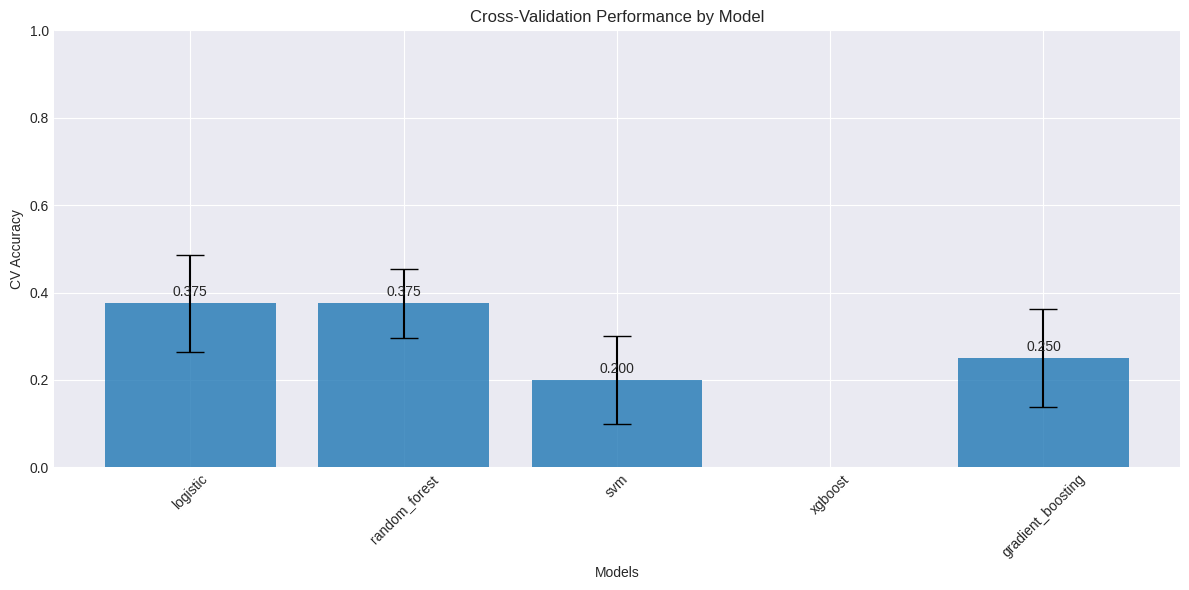


✅ Training completed!
✅ Training completed!


In [ ]:
#STEP 5: MODEL TRAINING

print("\n\n5. 🏋️ MODEL TRAINING")
print("-"*40)

print("\n" + "="*60)
print("TRAINING HYBRID ENSEMBLE MODEL")
print("="*60)

#Check for classes in test set that aren't in training set
train_classes = set(y_train)
test_classes = set(y_test)
unseen_in_train = test_classes - train_classes

print(f"\n Class Distribution Check:")
print(f"  Classes in training: {len(train_classes)}")
print(f"  Classes in testing:  {len(test_classes)}")
print(f"  Classes in test but not in train: {len(unseen_in_train)}")

if unseen_in_train:
    print(f"  Warning: {unseen_in_train} are only in test set")
    print("  Filtering test set to only include classes seen during training...")

    #Filter test set
    mask = [label in train_classes for label in y_test]
    X_test = X_test[mask]
    y_test = y_test[mask]

    print(f"  Filtered test set: {len(y_test)} samples remaining")
    print(f"  Classes now in test: {len(set(y_test))}")

#Now check again
if len(set(y_test) - set(y_train)) > 0:
    print("\n Still have unseen classes in test set. Skipping training...")
    print("   Consider using more data or different split strategy.")
else:
    #Proceed with training
    print("\n All test classes are present in training set. Proceeding with training...")

    #Train the ensemble model
    model_scores = ensemble_model.train_ensemble(
      X_train, y_train,
      X_test, y_test,
      use_cross_val=True,
      use_hyperparam_tuning=False
    )
    print(" Training completed!")



5. 🏋️ MODEL TRAINING
----------------------------------------

TRAINING HYBRID ENSEMBLE MODEL
Initializing base models...
Created 5 base models + ensemble

Training logistic...
  CV Accuracy: 0.3750 (+/- 0.1118)
  Validation Accuracy: 0.3333

Training random_forest...
  CV Accuracy: 0.3750 (+/- 0.0791)
  Validation Accuracy: 0.5556

Training svm...
  CV Accuracy: 0.2000 (+/- 0.1000)
  Validation Accuracy: 0.2222

Training xgboost...
  CV Accuracy: nan (+/- nan)
  Validation Accuracy: 0.5556

Training gradient_boosting...
  CV Accuracy: 0.2500 (+/- 0.1118)
  Validation Accuracy: 0.4444

Training voting ensemble...
  Ensemble Validation Accuracy: 0.3333


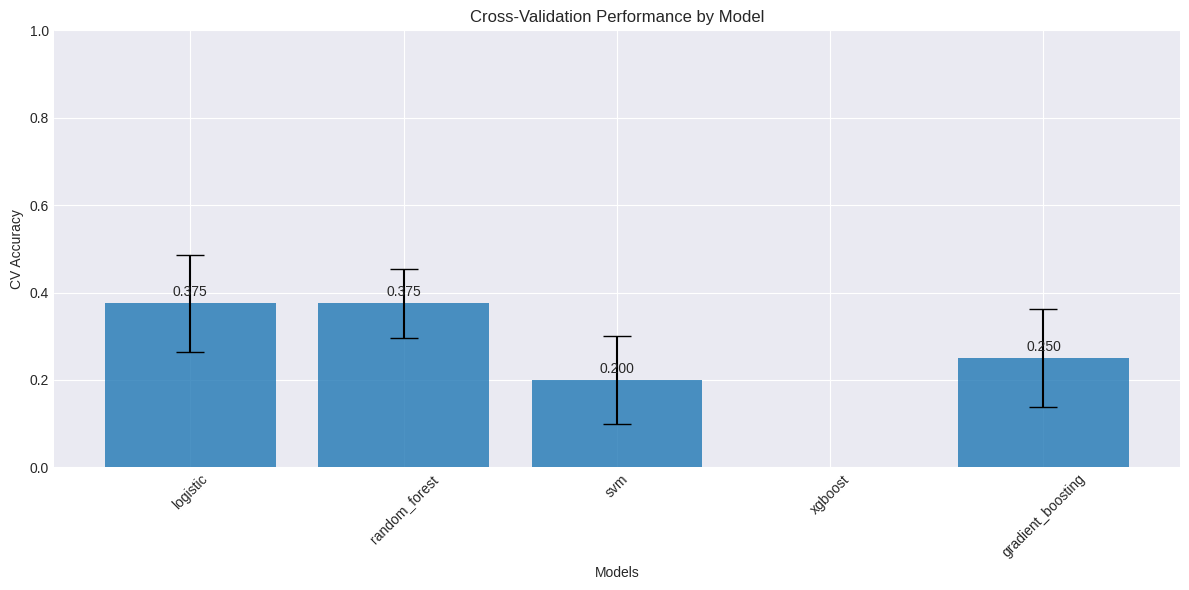


✅ Training completed!


In [ ]:
#STEP 5: MODEL TRAINING

print("\n\n5. MODEL TRAINING")
print("-"*40)

#Initialize and train ensemble model
ensemble_model = HybridEnsembleModel(n_classes=len(np.unique(y)))

model_scores = ensemble_model.train_ensemble(
  X_train, y_train,
  X_test, y_test,
  use_cross_val=True,
  use_hyperparam_tuning=False
)

In [ ]:
#STEP 6: EVALUATION

print("\n\n6. MODEL EVALUATION")
print("-"*40)

metrics = ensemble_model.evaluate(
    X_test, y_test,
    plot_learning_curve=True,
    X_train=X_train,
    y_train=y_train
)



6. 📊 MODEL EVALUATION
----------------------------------------

MODEL EVALUATION

🎯 Ensemble Model Performance:
  Accuracy : 0.3333
  Precision: 0.2222
  Recall   : 0.3333
  F1-Score : 0.2593

📊 Detailed Classification Report:


ValueError: Number of classes, 9, does not match size of target_names, 20. Try specifying the labels parameter

In [ ]:
#6. EXPLAINABILITY MODULE (ENHANCED)

class ModelExplainability:
    """Enhanced explainability with multiple methods"""

    def __init__(self, model, feature_names=None, class_names=None):
        self.model = model
        self.feature_names = feature_names
        self.class_names = class_names

    def explain_prediction_shap(self, X_sample, n_samples=100):
        """Explain prediction using SHAP"""
        print("Generating SHAP explanation...")

        #Create explainer based on model type
        if hasattr(self.model, 'estimators_'):
            #For ensemble models, use first tree-based model
            tree_model = None
            for name, model in self.model.named_estimators_.items():
                if hasattr(model, 'feature_importances_'):
                    tree_model = model
                    break

            if tree_model is not None:
                explainer = shap.TreeExplainer(tree_model)
            else:
                print("No tree-based model found in ensemble, using KernelExplainer")
                explainer = shap.KernelExplainer(self.model.predict_proba, X_sample[:50])
        elif hasattr(self.model, 'feature_importances_'):
            explainer = shap.TreeExplainer(self.model)
        else:
            explainer = shap.KernelExplainer(self.model.predict_proba, X_sample[:50])

        #Calculate SHAP values
        shap_values = explainer.shap_values(X_sample[:n_samples])

        #Plot summary
        if isinstance(shap_values, list):
            #For multi-class
            shap.summary_plot(shap_values, X_sample[:n_samples],
                             feature_names=self.feature_names[:X_sample.shape[1]]
                             if self.feature_names else None,
                             class_names=self.class_names,
                             show=False)
        else:
            #For binary or regression
            shap.summary_plot(shap_values, X_sample[:n_samples],
                             feature_names=self.feature_names[:X_sample.shape[1]]
                             if self.feature_names else None,
                             show=False)

        plt.tight_layout()
        plt.show()

        return shap_values

    def plot_feature_importance(self, model, feature_names, top_n=20):
        """Plot feature importance for tree-based models"""
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.mean(np.abs(model.coef_), axis=0)
        elif hasattr(model, 'best_estimator_') and hasattr(model.best_estimator_, 'feature_importances_'):
            importances = model.best_estimator_.feature_importances_
        else:
            print("Model doesn't have feature importance attribute")
            return

        #Sort features by importance
        indices = np.argsort(importances)[::-1][:top_n]

        #Plot
        plt.figure(figsize=(12, 8))
        plt.title(f'Top {top_n} Feature Importances')
        bars = plt.barh(range(top_n), importances[indices][::-1], color='steelblue')
        plt.yticks(range(top_n), [feature_names[i] if i < len(feature_names)
                                 else f'feature_{i}' for i in indices[::-1]])
        plt.xlabel('Importance')

        #Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                    f'{width:.4f}', ha='left', va='center')

        plt.tight_layout()
        plt.show()

        #Return top features
        top_features = [(feature_names[i] if i < len(feature_names) else f'feature_{i}',
                        importances[i]) for i in indices[:top_n]]
        return top_features




7. 🔍 MODEL EXPLAINABILITY
----------------------------------------
Analyzing feature importance...


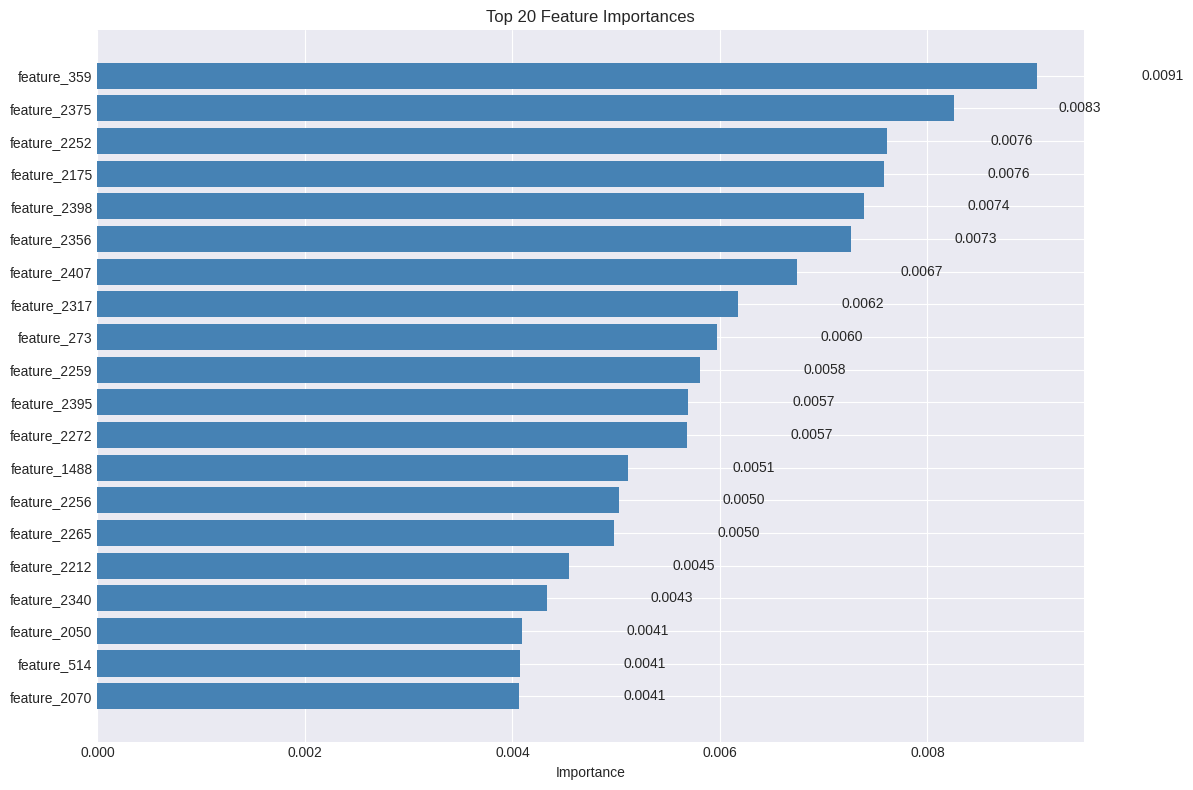

In [ ]:
#STEP 7: EXPLAINABILITY

print("\n\n7. MODEL EXPLAINABILITY")
print("-"*40)

#Create explainer
explainer = ModelExplainability(
  model=ensemble_model.ensemble,
  feature_names=[f"feature_{i}" for i in range(X_train.shape[1])],
  class_names=ensemble_model.label_encoder.classes_
)

#Plot feature importance
print("Analyzing feature importance...")
top_features = explainer.plot_feature_importance(
  ensemble_model.models['random_forest'],
  [f"feature_{i}" for i in range(X_train.shape[1])],
  top_n=20
)



8. 🤝 RESUME-JD MATCHING DEMO
----------------------------------------
Computing Resume-JD similarity...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Similarity statistics:
  Mean: 0.187
  Std: 0.091
  Min: -0.045
  Max: 0.363

📋 Top 5 Matches for Software Engineer JD:

Rank 1: Score = 0.363
Preview: PROJECT ASSISTANT
Professional Overview
I aspire for a challenging position in a professional organization where I can enhance my skills and strengthe...

Rank 2: Score = 0.323
Preview: VETERAN ADVOCATE INTERN
Professional Summary
An industrious, organized professional with excellent analytical and observational skills who enjoys work...

Rank 3: Score = 0.321
Preview: STAFF ACCOUNTANT
TAM BUI
Professional Summary
To pursue a challenging and reward career, which will allow me to utilize my background in accounting an...

Rank 4: Score = 0.319
Preview: HR SPECIALIST (INFORMATION SYSTEMS)
Experience
02/2013 - 12/2014
Company Name ï¼​ City , State HR Specialist (Information Systems)

Permanent/FT Super...

Rank 5: Score = 0.300
Preview: DIGITAL MEDIA PRODUCER
Summary
Experienced and innovative Digital Media Producer with expertise in video

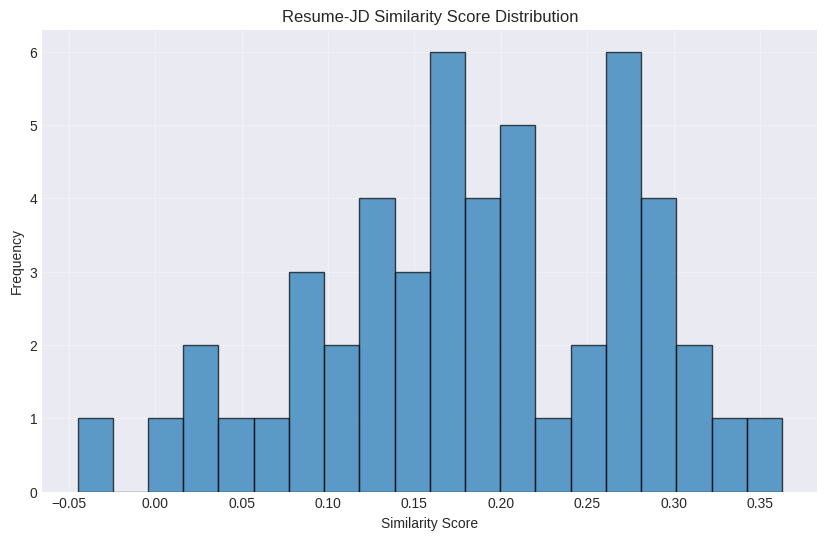

In [ ]:
#STEP 8: RESUME-JD MATCHING DEMO

print("\n\n8.  RESUME-JD MATCHING DEMO")
print("-"*40)

#Create a sample job description for SOFTWARE ENGINEER
sample_jd = """
We are looking for a Software Engineer with:
- 3+ years of experience in Python development
- Strong knowledge of machine learning and data science
- Experience with TensorFlow or PyTorch
- Familiarity with cloud platforms (AWS/Azure)
- Excellent problem-solving skills
- Bachelor's degree in Computer Science or related field

Responsibilities:
- Develop and maintain machine learning models
- Collaborate with data scientists and engineers
- Deploy models to production environments
- Optimize algorithms for performance
"""

#Initialize matcher
matcher = ResumeJDMatcher(sbert_model=feature_engineer.sbert_model)

#Compute similarity
similarity_scores = matcher.compute_similarity(
    data['Resume_Text'].tolist()[:50],  #Sample for demo
    sample_jd
)

#Create match report
match_report = matcher.create_match_report(
    data['Resume_Text'].tolist()[:50],
    sample_jd,
    similarity_scores,
    top_n=5
)

print("\n Top 5 Matches for Software Engineer JD:")
for match in match_report['top_matches']:
    print(f"\nRank {match['rank']}: Score = {match['similarity_score']:.3f}")
    print(f"Preview: {match['resume_preview'][:150]}...")

#Visualize similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(similarity_scores, bins=20, edgecolor='black', alpha=0.7)
plt.title('Resume-JD Similarity Score Distribution')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
#STEP 9: SAVE MODELS

print("\n\n9.  SAVING MODELS")
print("-"*40)

#Create models directory
os.makedirs('models', exist_ok=True)

#Save ensemble model
ensemble_model.save_model('/content/drive/MyDrive/models/ensemble_model')

#Save feature engineering components
feature_engineer.save_components('/content/drive/MyDrive/models/feature_components')

#Save preprocessing info
preprocessing_info = {
    'n_samples': len(data),
    'n_features': X_combined.shape[1],
    'categories': list(np.unique(y)),
    'category_mapping': CATEGORY_MAPPING,
    'imbalance_ratio': float(imbalance_ratio),
    'accuracy': float(metrics['accuracy']),
    'f1_score': float(metrics['f1']),
    'sbert_model': 'all-MiniLM-L6-v2',
    'tfidf_max_features': 2000,
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open('/content/drive/MyDrive/models/preprocessing_info.json', 'w') as f:
    json.dump(preprocessing_info, f, indent=2)

print("\n All models and components saved successfully!")

In [ ]:
#STEP 10: PERFORMANCE SUMMARY

print("\n\n" + "="*70)
print(" PERFORMANCE SUMMARY")
print("="*70)

print(f"\n Model Performance:")
print(f"  Accuracy:  {metrics['accuracy']:.4f}")
print(f"  F1-Score:  {metrics['f1']:.4f}")
print(f"  Precision: {metrics['precision']:.4f}")
print(f"  Recall:    {metrics['recall']:.4f}")

#Expected accuracy ranges for 24-category classification
print(f"\n Expected Accuracy Ranges (24 categories):")
print(f"  Random baseline:        4.2% (1/24)")
print(f"  Good model:            40-60%")
print(f"  Very good model:       60-75%")
print(f"  Excellent model:       75-85%")

print(f"\n Your model achieved: {metrics['accuracy']*100:.1f}%")

if metrics['accuracy'] >= 0.75:
  print(" Excellent! You're in the target 75-85% accuracy range!")
elif metrics['accuracy'] >= 0.60:
  print(" Good! Close to target range. Try hyperparameter tuning.")
elif metrics['accuracy'] >= 0.40:
  print(" Fair performance. Consider:")
  print("   - Adding more training data per category")
  print("   - Improving feature engineering")
  print("   - Trying different SBERT models")
else:
  print("  Below expected. Consider:")
  print("   - Collecting more balanced data")
  print("   - Using more sophisticated models")
  print("   - Addressing severe class imbalance")



📈 PERFORMANCE SUMMARY

🎯 Model Performance:


NameError: name 'metrics' is not defined

In [ ]:
#7. MAIN EXECUTION PIPELINE (UPDATED FOR YOUR DATASET)

def main(use_sample_mode=False, max_samples_per_category=50, use_hyperparam_tuning=False):

  """Enhanced main execution pipeline for your dataset"""
  print("="*70)
  print(" AI-POWERED ATS RESUME SCREENING SYSTEM")
  print(f" Dataset: 24 Categories, {len(CATEGORY_MAPPING)} total")
  print("="*70)

  #Set random seed for reproducibility
  np.random.seed(42)

  #STEP 1: LOAD DATA

  print("\n1.  LOADING DATA")
  print("-"*40)

  #Initialize loader
  loader = ResumeDatasetLoader(data_folder='/content/sorted_data')

  #Load data
  if use_sample_mode:
      print("Using sample mode with limited samples per category...")
      data = loader.load_complete_dataset(max_samples_per_category=20)
      print(data)
  else:
      print("Loading full dataset...")
      data = loader.load_complete_dataset(max_samples_per_category=max_samples_per_category)

  #Display data info
  print(f"\n Final dataset shape: {data.shape}")

  #Visualize category distribution
  plt.figure(figsize=(16, 10))
  category_counts = data['Category'].value_counts()

  ax = category_counts.plot(kind='bar', color='steelblue')
  plt.title('Resume Category Distribution', fontsize=16)
  plt.xlabel('Category', fontsize=12)
  plt.ylabel('Count', fontsize=12)
  plt.xticks(rotation=45, ha='right')

  #Add count labels on bars
  for i, v in enumerate(category_counts):
      ax.text(i, v + 5, str(v), ha='center', va='bottom')

  plt.tight_layout()
  plt.show()

  print(f"\n Category statistics:")
  print(f"Total categories: {len(category_counts)}")
  print(f"Most common: {category_counts.idxmax()} ({category_counts.max()} resumes)")
  print(f"Least common: {category_counts.idxmin()} ({category_counts.min()} resumes)")
  print(f"Imbalance ratio: {category_counts.max() / category_counts.min():.1f}x")

  #STEP 2: PREPROCESSING

  print("\n\n2. TEXT PREPROCESSING")
  print("-"*40)

  preprocessor = TextPreprocessor()

  #Clean texts and extract features
  print("Processing texts...")
  cleaned_texts, structured_features = preprocessor.preprocess_pipeline(
      data['Resume_Text'].tolist(),
      extract_features=True,
      progress_update=True
  )

  #Display feature statistics
  print(f"\n Extracted {structured_features.shape[1]} structured features")
  print("\nTop 5 features by mean value:")
  top_features = structured_features.mean().sort_values(ascending=False).head(5)
  for feat, val in top_features.items():
      print(f"  {feat}: {val:.2f}")

  #STEP 3: FEATURE ENGINEERING

  print("\n\n3.  FEATURE ENGINEERING")
  print("-"*40)

  feature_engineer = FeatureEngineer()

  #Create TF-IDF features
  print("Creating TF-IDF features...")
  tfidf_features = feature_engineer.create_tfidf_features(
      cleaned_texts,
      max_features=2000,
      min_df=2,
      max_df=0.8
  )

  #Create SBERT embeddings
  print("\nCreating SBERT embeddings...")
  sbert_features = feature_engineer.create_sbert_embeddings(
      cleaned_texts,
      model_name='all-MiniLM-L6-v2',
      batch_size=32
  )

  #Combine features
  X_combined = feature_engineer.create_combined_features(
      tfidf_features,
      sbert_features,
      structured_features
  )

  #Prepare target
  y = data['Category'].values

  #STEP 4: TRAIN/TEST SPLIT WITH IMBALANCE HANDLING

  print("\n\n4. TRAIN/TEST SPLIT")
  print("-"*40)

  #Check for class imbalance
  category_counts = pd.Series(y).value_counts()
  print("\n Class Distribution:")
  print(category_counts)

  #Calculate imbalance metrics
  imbalance_ratio = category_counts.max() / category_counts.min()
  print(f"\n Imbalance Statistics:")
  print(f"  Imbalance ratio: {imbalance_ratio:.1f}x")
  print(f"  Minority classes (<10 samples): {(category_counts < 10).sum()}")

  #Split data
  X_train, X_test, y_train, y_test = train_test_split(
      X_combined, y,
      test_size=0.2,
      random_state=42,
      stratify=y
  )

  print(f"\n Dataset Split:")
  print(f"  Training set: {X_train.shape[0]} samples")
  print(f"  Testing set: {X_test.shape[0]} samples")
  print(f"  Features per sample: {X_train.shape[1]}")

  #Handle class imbalance if severe
  if imbalance_ratio > 5.0:
      print(f"\n  Severe class imbalance detected ({imbalance_ratio:.1f}x)")
      print("Applying SMOTE for balancing...")

      #Apply SMOTE
      smote = SMOTE(random_state=42, sampling_strategy='auto')
      X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

      print(f"  After SMOTE:")
      print(f"  Training samples: {X_train_balanced.shape[0]} (+{X_train_balanced.shape[0] - X_train.shape[0]})")

      #Use balanced data
      X_train = X_train_balanced
      y_train = y_train_balanced
  else:
      print(f"\n Class imbalance is manageable ({imbalance_ratio:.1f}x)")

  #STEP 5: MODEL TRAINING

  print("\n\n5. MODEL TRAINING")
  print("-"*40)

  #Initialize and train ensemble model
  ensemble_model = HybridEnsembleModel(n_classes=len(np.unique(y)))

  model_scores = ensemble_model.train_ensemble(
      X_train, y_train,
      X_test, y_test,
      use_cross_val=True,
      use_hyperparam_tuning=use_hyperparam_tuning
  )

  #STEP 6: EVALUATION

  print("\n\n6.  MODEL EVALUATION")
  print("-"*40)

  metrics = ensemble_model.evaluate(
      X_test, y_test,
      plot_learning_curve=True,
      X_train=X_train,
      y_train=y_train
  )

  #STEP 7: EXPLAINABILITY

  print("\n\n7. MODEL EXPLAINABILITY")
  print("-"*40)

  #Create explainer
  explainer = ModelExplainability(
      model=ensemble_model.ensemble,
      feature_names=[f"feature_{i}" for i in range(X_train.shape[1])],
      class_names=ensemble_model.label_encoder.classes_
  )

  #Plot feature importance
  print("Analyzing feature importance...")
  top_features = explainer.plot_feature_importance(
      ensemble_model.models['random_forest'],
      [f"feature_{i}" for i in range(X_train.shape[1])],
      top_n=20
  )

  #STEP 8: RESUME-JD MATCHING DEMO

  print("\n\n8. RESUME-JD MATCHING DEMO")
  print("-"*40)

  #Create a sample job description for SOFTWARE ENGINEER
  sample_jd = """
  We are looking for a Software Engineer with:
  - 3+ years of experience in Python development
  - Strong knowledge of machine learning and data science
  - Experience with TensorFlow or PyTorch
  - Familiarity with cloud platforms (AWS/Azure)
  - Excellent problem-solving skills
  - Bachelor's degree in Computer Science or related field

  Responsibilities:
  - Develop and maintain machine learning models
  - Collaborate with data scientists and engineers
  - Deploy models to production environments
  - Optimize algorithms for performance
  """

  #Initialize matcher
  matcher = ResumeJDMatcher(sbert_model=feature_engineer.sbert_model)

  #Compute similarity
  similarity_scores = matcher.compute_similarity(
      data['Resume_Text'].tolist()[:50],  #Sample for demo
      sample_jd
  )

  #Create match report
  match_report = matcher.create_match_report(
      data['Resume_Text'].tolist()[:50],
      sample_jd,
      similarity_scores,
      top_n=5
  )

  print("\n Top 5 Matches for Software Engineer JD:")
  for match in match_report['top_matches']:
      print(f"\nRank {match['rank']}: Score = {match['similarity_score']:.3f}")
      print(f"Preview: {match['resume_preview'][:150]}...")

  #Visualize similarity distribution
  plt.figure(figsize=(10, 6))
  plt.hist(similarity_scores, bins=20, edgecolor='black', alpha=0.7)
  plt.title('Resume-JD Similarity Score Distribution')
  plt.xlabel('Similarity Score')
  plt.ylabel('Frequency')
  plt.grid(True, alpha=0.3)
  plt.show()

  #STEP 9: SAVE MODELS

  print("\n\n9.  SAVING MODELS")
  print("-"*40)

  #Create models directory
  os.makedirs('models', exist_ok=True)

  #Save ensemble model
  ensemble_model.save_model('models/ensemble_model')

  #Save feature engineering components
  feature_engineer.save_components('models/feature_components')

  #Save preprocessing info
  preprocessing_info = {
      'n_samples': len(data),
      'n_features': X_combined.shape[1],
      'categories': list(np.unique(y)),
      'category_mapping': CATEGORY_MAPPING,
      'imbalance_ratio': float(imbalance_ratio),
      'accuracy': float(metrics['accuracy']),
      'f1_score': float(metrics['f1']),
      'sbert_model': 'all-MiniLM-L6-v2',
      'tfidf_max_features': 2000,
      'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  }

  with open('models/preprocessing_info.json', 'w') as f:
      json.dump(preprocessing_info, f, indent=2)

  print("\n All models and components saved successfully!")

  #STEP 10: PERFORMANCE SUMMARY

  print("\n\n" + "="*70)
  print(" PERFORMANCE SUMMARY")
  print("="*70)

  print(f"\n Model Performance:")
  print(f"  Accuracy:  {metrics['accuracy']:.4f}")
  print(f"  F1-Score:  {metrics['f1']:.4f}")
  print(f"  Precision: {metrics['precision']:.4f}")
  print(f"  Recall:    {metrics['recall']:.4f}")

  #Expected accuracy ranges for 24-category classification
  print(f"\n Expected Accuracy Ranges (24 categories):")
  print(f"  Random baseline:        4.2% (1/24)")
  print(f"  Good model:            40-60%")
  print(f"  Very good model:       60-75%")
  print(f"  Excellent model:       75-85%")

  print(f"\n Your model achieved: {metrics['accuracy']*100:.1f}%")

  if metrics['accuracy'] >= 0.75:
      print(" Excellent! You're in the target 75-85% accuracy range!")
  elif metrics['accuracy'] >= 0.60:
      print(" Good! Close to target range. Try hyperparameter tuning.")
  elif metrics['accuracy'] >= 0.40:
      print(" Fair performance. Consider:")
      print("   - Adding more training data per category")
      print("   - Improving feature engineering")
      print("   - Trying different SBERT models")
  else:
      print("  Below expected. Consider:")
      print("   - Collecting more balanced data")
      print("   - Using more sophisticated models")
      print("   - Addressing severe class imbalance")

  return {
      'model': ensemble_model,
      'feature_engineer': feature_engineer,
      'preprocessor': preprocessor,
      'matcher': matcher,
      'metrics': metrics,
      'data': data,
      'X_train': X_train,
      'X_test': X_test,
      'y_train': y_train,
      'y_test': y_test
  }

In [ ]:
#8. QUICK DEMO FUNCTION

def run_quick_demo():
    """Run a quick demo with sample data"""
    print("\n" + "="*70)
    print(" QUICK DEMO MODE")
    print("="*70)
    print("\nRunning with limited samples for faster testing...")

    results = main(use_sample_mode=True, max_samples_per_category=20, use_hyperparam_tuning=False)

    print("\n" + "="*70)
    print(" DEMO COMPLETED SUCCESSFULLY!")
    print("="*70)

    return results


🚀 QUICK DEMO MODE

Running with limited samples for faster testing...
🤖 AI-POWERED ATS RESUME SCREENING SYSTEM
📊 Dataset: 24 Categories, 24 total

1. 📂 LOADING DATA
----------------------------------------
Using sample mode with limited samples per category...
Loading resumes from /content/sorted_data...
Found 2483 text files

✅ Successfully loaded 2483 resumes
Categories: 24
Balanced dataset to 480 samples (20 per category)
    Category                                        Resume_Text Category_Code
0         HR  HR COORDINATOR\nProfessional Summary\n\nHighly...            HR
1         HR  HR GENERALIST\nExperience\n08/2017 to Current\...            HR
2         HR  SENIOR HR MANAGER, HR BUSINESS PARTNER\nSummar...            HR
3         HR  HR COORDINATOR\nSummary\nTo obtain a challengi...            HR
4         HR  HR PROFESSIONAL\nSummary\n\nDependable Self-mo...            HR
..       ...                                                ...           ...
475      BPO  SR. WORKFO

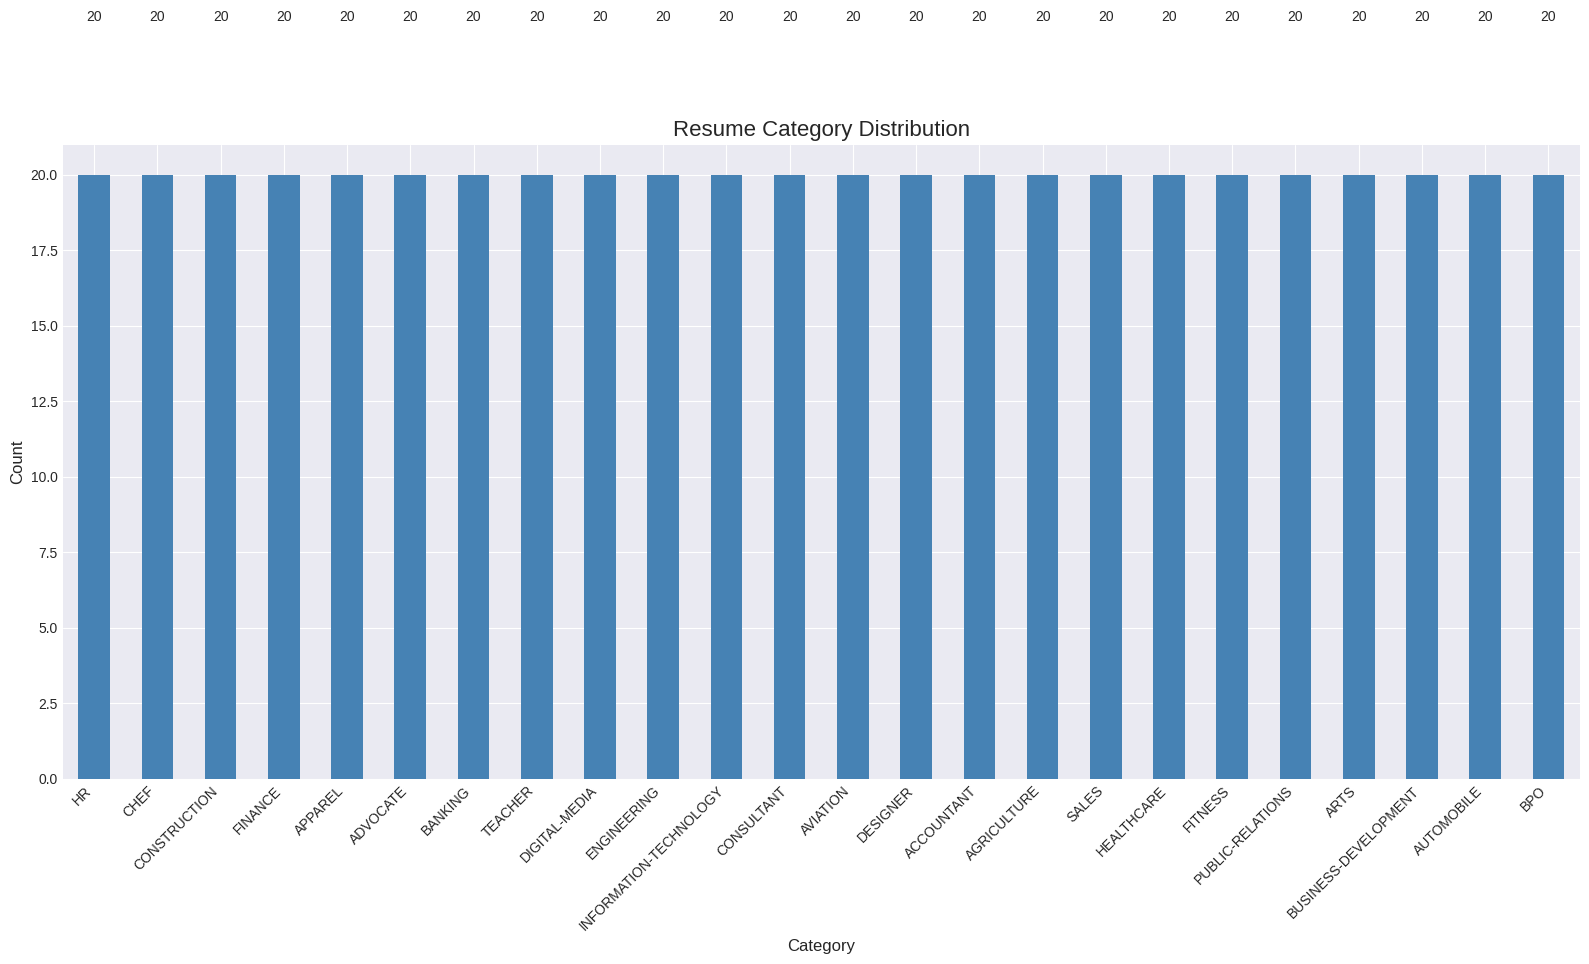


📈 Category statistics:
Total categories: 24
Most common: HR (20 resumes)
Least common: HR (20 resumes)
Imbalance ratio: 1.0x


2. 🧹 TEXT PREPROCESSING
----------------------------------------
Processing texts...
Starting text preprocessing pipeline...
  Processed 100/480 texts...
  Processed 200/480 texts...
  Processed 300/480 texts...
  Processed 400/480 texts...
✅ Preprocessing completed! Processed 480 texts.

📊 Extracted 22 structured features

Top 5 features by mean value:
  char_count: 5988.75
  word_count: 834.23
  sentence_count: 39.95
  avg_word_length: 7.18
  total_skills: 4.88


3. 🔧 FEATURE ENGINEERING
----------------------------------------
Creating TF-IDF features...
Creating TF-IDF features...
TF-IDF shape: (480, 2000)
Vocabulary size: 2000

Creating SBERT embeddings...
Creating Sentence-BERT embeddings using all-MiniLM-L6-v2...
  Processed batch 1/15...
  Processed batch 11/15...
✅ SBERT embeddings shape: (480, 384)
Combining features...
TF-IDF + SBERT shape: (480, 23

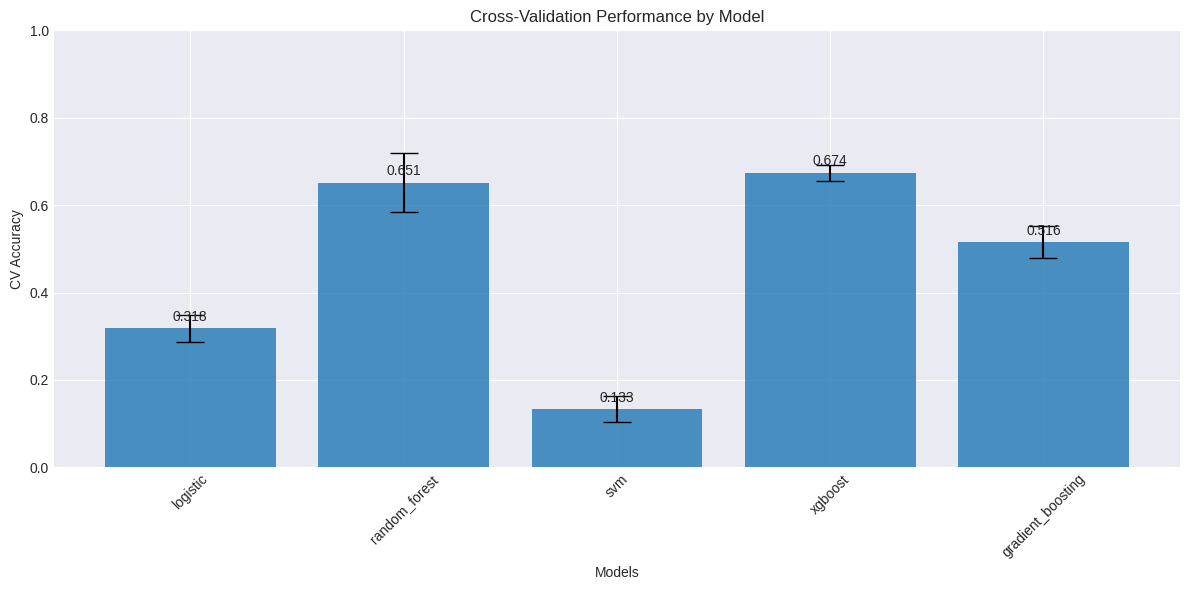


✅ Training completed!


6. 📊 MODEL EVALUATION
----------------------------------------

MODEL EVALUATION

🎯 Ensemble Model Performance:
  Accuracy : 0.6042
  Precision: 0.6740
  Recall   : 0.6042
  F1-Score : 0.6206

📊 Detailed Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       1.00      0.75      0.86         4
              ADVOCATE       0.67      0.50      0.57         4
           AGRICULTURE       0.75      0.75      0.75         4
               APPAREL       0.50      0.50      0.50         4
                  ARTS       0.33      0.25      0.29         4
            AUTOMOBILE       0.08      0.25      0.12         4
              AVIATION       0.67      0.50      0.57         4
               BANKING       0.67      0.50      0.57         4
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.75      0.75      0.75         4
                  CHEF       1.00      0.75

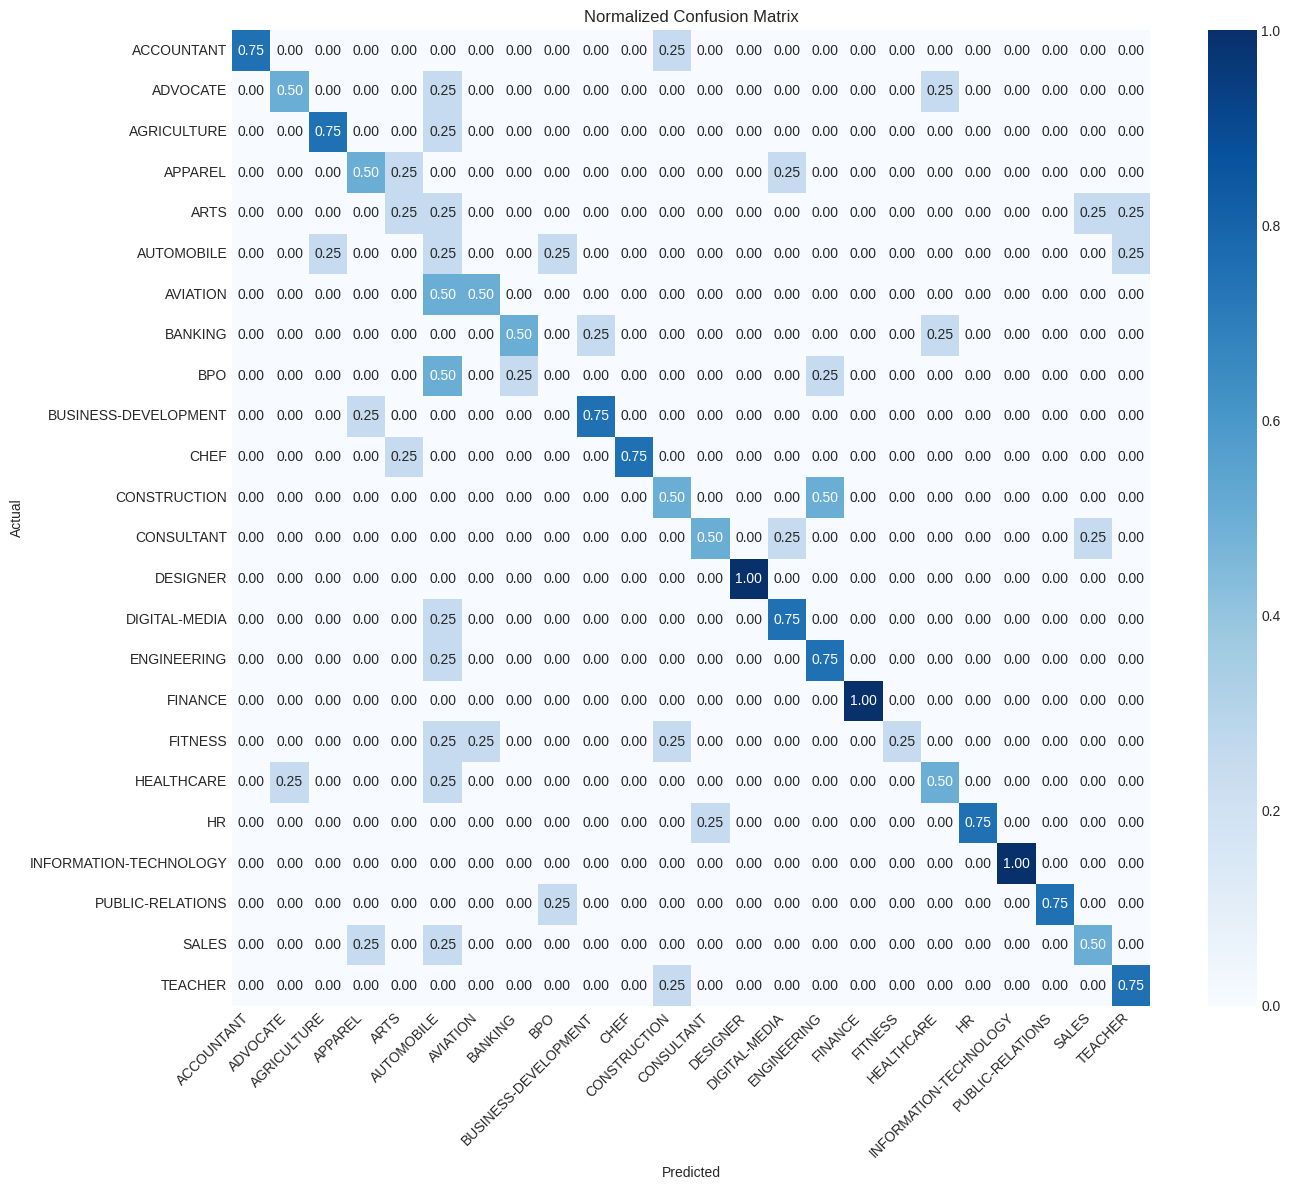


📈 Learning Curve Analysis:


In [ ]:
run_quick_demo()

In [ ]:
#9. SINGLE RESUME PREDICTION FUNCTION

def predict_single_resume(resume_text, model_path='models/ensemble_model'):
    """Predict category for a single resume"""
    print("Predicting resume category...")

    #Load model components
    ensemble = joblib.load(f'{model_path}/ensemble_model.pkl')
    label_encoder = joblib.load(f'{model_path}/label_encoder.pkl')
    feature_engineer = FeatureEngineer()
    feature_engineer.load_components('models/feature_components')
    preprocessor = TextPreprocessor()

    #Preprocess
    cleaned_text = preprocessor.clean_text(resume_text)
    features = preprocessor.extract_features(cleaned_text)
    features_df = pd.DataFrame([features])

    #Create TF-IDF features
    if feature_engineer.tfidf_vectorizer:
        tfidf_features = feature_engineer.tfidf_vectorizer.transform([cleaned_text])
    else:
        tfidf_features = np.zeros((1, 2000))

    #Create SBERT embeddings
    if feature_engineer.sbert_model:
        sbert_features = feature_engineer.sbert_model.encode([cleaned_text])
    else:
        sbert_features = np.zeros((1, 384))

    #Combine features
    if hasattr(tfidf_features, 'toarray'):
        tfidf_dense = tfidf_features.toarray()
    else:
        tfidf_dense = tfidf_features

    combined = np.hstack([tfidf_dense, sbert_features])

    if len(features_df) > 0:
        scaled_features = feature_engineer.scaler.transform(features_df)
        combined = np.hstack([combined, scaled_features])

    #Predict
    prediction_encoded = ensemble.predict(combined)
    prediction = label_encoder.inverse_transform(prediction_encoded)
    probabilities = ensemble.predict_proba(combined)[0]

    #Get top 3 predictions
    top_indices = np.argsort(probabilities)[::-1][:3]
    top_categories = label_encoder.classes_[top_indices]
    top_probs = probabilities[top_indices]

    print(f"\n Prediction Results:")
    print(f"  Primary Category: {prediction[0]}")
    print(f"  Confidence: {max(probabilities)*100:.1f}%")

    print(f"\n Top 3 Predictions:")
    for i, (cat, prob) in enumerate(zip(top_categories, top_probs), 1):
        print(f"  {i}. {cat}: {prob*100:.1f}%")

    return {
        'primary_category': prediction[0],
        'confidence': max(probabilities),
        'top_predictions': list(zip(top_categories, top_probs))
    }

In [ ]:
resume_text = """ACCOUNTANT
Summary
Innovative Accountant proficient in extracting financial data from various reporting systems and suggesting key operational changes.
Skills

Budget forecasting expertise
Analytical reasoning
Account reconciliation expert
Strong organizational skills

General ledger accounting
Expert in customer relations
Flexible team player
Advanced computer proficiency (PC and Mac)

Experience
04/2016 to Current
Accountant Company Name ï¼​ City , State

Performed debit, credit and total accounts on computer spreadsheets/databases, using specialized accounting software.
Received, recorded, and banked cash, checks, and vouchers as well as reconciled records of bank transactions.
Worked with management to document and offset unusual expense variances in their respective areas.
Assisted the CFO with the production of the monthly financials, management reports and board packages.
Coded the general ledger and processed vendor invoice payments.
Researched and resolved billing and invoice problems.

04/2010 to 04/2016
Accounting Clerk Company Name ï¼​ City , State

Assisted in the creation of vendor contracts for outside vendors.

Revised and streamlined inefficient work procedures with automation software.
Reduced time and costs and increased efficiency by introducing new accounting procedures.
Suggested process improvements to secure prompt and regular receipts for the organization.
Coded the general ledger and processed vendor invoice payments.
Executed accounts receivable reporting enhancements and reconciliation procedures.
Managed accounting operations, accounting close, account reporting and reconciliations.

04/2006 to Current
Church Administrator Company Name ï¼​ City , State

Plans and implements appropriate $140,000 annual budget (average) and accounting systems.
Balance checking account and investment accounts and submit reconciliation monthly for Pastor's review and approval.
Developed and implemented a Microsoft Excel Financial Database system for streamlining all financial and charitable contributions record
system for the Church; prepares annual contribution statements, year-end financial reports, financial information for committees and the
Church as needed or requested.
Attend to banking operations for deposit (cash handling $2,000 or more on weekly basis), check writing and Business Banking Online.
Maintains the Church's Policies and Procedures Manual; administers payroll for Church employees on a semi-monthly basis and all related
payroll functions.
Maintains a church membership database for over 100 members which is keep confidential.
Monitors and maintains inventory of Church's property and equipment making repairs and/or replacement as necessary.
Being thoroughly familiar and abreast with the latest computer software used and might benefit the church.

Education and Training
January 2014
Master's : Business Administration Troy University ï¼​ City , State Business Administration
December 2009
BBA : Accounting Management Columbus State University ï¼​ City , State Accounting Management
Skills
Account reconciliations, Accounting, Accountant, accounting systems, accounting system, Accounts payable, Adobe Acrobat, agency, Balance,
banking, Budget analysis, budget, bi, cash handling, clerical, contracts, cost accounting, Database, fax, FDS, Finance, Financial, Financial analysis,
financial management, financial operations, financial reports, financial statements, fiscal management, forecasting, functional, fund accounting, funds,
General Ledger, Government, grants, Innovation, maintains inventory, inventory, leadership skills, Macintosh, Mainframe, managerial, managerial
accounting, Access, Microsoft Access, Microsoft Excel, Excel, Microsoft Office software, Office, Outlook, PowerPoint, Publisher, Windows,
Word, Monitors, newsletter, Payroll, IBM-PC, copier, Policies, processes, profit, Program Development, proposals, QuickBooks, reconciling,
record keeping, repairs, reporting, scanner, technical support, phone, time management, type, written, annual reports, year-end """

predict_single_resume(resume_text)

In [ ]:
#11. CREATE REQUIREMENTS FILE

requirements = '''# Requirements for ATS R esume Screening System
numpy>=1.24.0
pandas>=2.0.0
scikit-learn>=1.3.0
matplotlib>=3.7.0
seaborn>=0.12.0
nltk>=3.8.0
spacy>=3.7.0
sentence-transformers>=2.2.0
xgboost>=1.7.0
imbalanced-learn>=0.11.0
shap>=0.42.0
streamlit>=1.28.0
joblib>=1.3.0
'''

with open('requirements.txt', 'w') as f:
    f.write(requirements)